
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries

inputs required: 
  * Historical DWTs
  * Historical AWT and IWT
  * Synthetic timeseries of AWT and IWT
  * Historical wave families 
  * Historical intradaily hydrograph parameters
  * TCs waves
  
in this notebook:
  * Fit a multivariate extreme model for the waves associated to each DWT
  * Generate synthetic time series of wave conditions
  * Validate the synthetic waves by means of mean distributions



### Workflow:

<div>
<img src="resources/nb01_12.png" width="400px">
</div>



The **synthetic generation of wave conditions on a regular climate** (DWT1-36) is based on the work of Rueda et al. 2017. The probability of SW1, SW2, and SEA components being present (1) or not present (0) at the time of observed peak TWLproxy was used to create eight potential sea-states within each DWT (000, 100, 010, 001, 110, 101, 011, 111) defined by Bernoulli distributions . For each hydrograph produced in the simulations of climate, a random pick from the appropriate Bernoulli distribution determined which sea state was present during that hydrograph. A subsequent random pick from the assigned sea state’s marginal distributions defined the waves at the maximum TWL peak within the simulated hydrograph.

The marginal distributions of waves and surge levels were associated with each other using multivariate gaussian copulas. The copulas define the dependence structure, or joint probabilities, between each environmental parameter within a sea state by identifying correlation matrices after transforming each marginal distribution to a uniform distribution. Identifying the correlation across all parameters through the copulas ensures that realistic combinations of compounding environmental parameters are present in the hypothetical time series (i.e., large storm waves approach from appropriate wave directions) (Masina et al. 2015; Corbella & Stretch, 2013). The marginal distributions of wave heights were defined by GEVs to allow for simulation of extremes with longer return periods than the observation period, while wave periods and directions were defined by empirical distributions constructed from observations. 

Additional parameters including τ (timing of the peak TWL within a hydrograph) and μ (area under the hydrograph) were also added to each copula and randomly sampled for each simulated hydrograph. The two parameters effectively define a trapezoidal shape for each simulated hydrograph, analogous to the storm schematization of other recent works (e.g., Poelhekke et al., 2016). Including these parameters in the copulas accounts for correlation between storminess and hydrograph shape (peaky hydrographs are commonly associated with storm conditions while more flat hydrographs typically occur during calmer conditions). The shape of the simulated hydrograph will be use to interpolate to an hourly value of the TWLproxy, and subsequently an hourly value of wave conditions *(notebook 14)*

In the case on **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in *notebook 07* are use whenever the simulated TC enters the 4 degrees radio.




In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# for user inputs
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# for input configuration
import sys
sys.path.append('../../..')  # Appending parent directory to Python path
from input_configuration import *

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator_lim_hydrograph_days import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ, Plot_FitSim_EmpFit

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# Teslakit database

p_data = p_data_input
db = Database(p_data)

# make a new site
db.MakeNewSite(site_name)

Teslakit Site already exists at C:/Users/fergusonpc/Teslakit-SF-Final\sites\SF_Test5


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point

print(WVS)
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# Load extra vairables to include in WVS
ss = db.Load_storm_surge()
print(ss)

# hourly sea level pressure
PRMSL_L101 = db.Load_sea_level_pressure()
print(PRMSL_L101)

# hourly wind u
U_GRD_L103 = db.Load_wind_u()
print(U_GRD_L103)

# hourly wind v
V_GRD_L103 = db.Load_wind_v()
print(V_GRD_L103)

<xarray.Dataset>
Dimensions:      (time: 350640)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    TC_category  (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1
<xarray.Dataset>
Dimensions:  (time: 350640)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    ss       (time) float64 ...
<xarray.Dataset>
Dimensions:     (time: 350640)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    PRMSL_L1

In [4]:
# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 
# 1-100 simulations
DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])

In [5]:
# solve first 10 DWTs simulations
sim_range = np.arange(0,num_sims_input/10) # originally 100 -PF 20240724
DWTs_sim = DWTs_sim.isel(n_sim=sim_range)

print(DWTs_sim)

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 182987)
Coordinates:
  * time         (time) object 2000-06-01 00:00:00 ... 2501-06-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1



## Climate Emulator - Fitting

In [6]:
# Waves and KMA bmus data share time limits
WVS_fit = WVS.sel(time = slice(DWTs_fit.time[0], DWTs_fit.time[-1]))

# Waves AWL proxy variable for max. storms
WVS_fit['AWL'] = AWL(WVS_fit['Hs'], WVS_fit['Tp'])

WVS_fit['time'] = WVS_fit['time'].dt.floor('us') # weird thing where millisecond precision is lost so set back to zero

# resample extra data-ss
xtr_var = ss.resample(time='1h').pad().sel(time=WVS_fit.time)
print(xtr_var)

# add extra data to WAVES dataset
WVS_fit['storm_surge'] = xtr_var.ss
print(WVS_fit)

print('% complete storm surge:')
print((len(WVS_fit['storm_surge']) - len(WVS_fit['storm_surge'].loc[dict(time = np.isnan(WVS_fit['storm_surge']))]))/len(WVS_fit['storm_surge']))

# resample extra data-slp
xtr_var = PRMSL_L101.resample(time='1h').pad().sel(time=WVS_fit.time)
print(xtr_var)

# add extra data to WAVES dataset
WVS_fit['sea_level_pressure'] = xtr_var.PRMSL_L101
print(WVS_fit)

print('% complete sea level pressure:')
print((len(WVS_fit['sea_level_pressure']) - len(WVS_fit['sea_level_pressure'].loc[dict(time = np.isnan(WVS_fit['sea_level_pressure']))]))/len(WVS_fit['sea_level_pressure']))

# resample extra data-wind u
xtr_var = U_GRD_L103.resample(time='1h').pad().sel(time=WVS_fit.time)
print(xtr_var)

# add extra data to WAVES dataset
WVS_fit['wind_u'] = xtr_var.U_GRD_L103
print(WVS_fit)

print('% complete wind u:')
print((len(WVS_fit['wind_u']) - len(WVS_fit['wind_u'].loc[dict(time = np.isnan(WVS_fit['wind_u']))]))/len(WVS_fit['wind_u']))

# resample extra data-wind v
xtr_var = V_GRD_L103.resample(time='1h').pad().sel(time=WVS_fit.time)
print(xtr_var)

# add extra data to WAVES dataset
WVS_fit['wind_v'] = xtr_var.V_GRD_L103
print(WVS_fit)

print('% complete wind v:')
print((len(WVS_fit['wind_v']) - len(WVS_fit['wind_v'].loc[dict(time = np.isnan(WVS_fit['wind_v']))]))/len(WVS_fit['wind_v']))

<xarray.Dataset>
Dimensions:  (time: 350137)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-21 1979-01-21T01:00:00 ... 2018-12-31
Data variables:
    ss       (time) float64 -0.06653 -0.06665 -0.05484 ... -0.0954 -0.05577
<xarray.Dataset>
Dimensions:      (time: 350137)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-21 ... 2018-12-31
Data variables:
    Hs           (time) float64 2.257 2.214 2.173 2.136 ... 3.077 3.064 3.059
    Tp           (time) float64 14.16 14.11 14.07 14.01 ... 15.03 14.88 14.75
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    TC_category  (time) float64 ...
    AWL          (time) float64 0.9137 0.9022 0.8909 ... 1.133 1.119 1.109

In [7]:
# cannot have nans or zeros in extra vars TS
WVS_fit['storm_surge'].loc[dict(time = np.isnan(WVS_fit['storm_surge']))] = 0.0000001
WVS_fit['storm_surge'].loc[dict(time = np.isnan(WVS_fit['storm_surge']))]

# one standard atmosphere, or 101.325 kilopascals.
WVS_fit['sea_level_pressure'].loc[dict(time = np.isnan(WVS_fit['sea_level_pressure']))] = 101325
WVS_fit['sea_level_pressure'].loc[dict(time = np.isnan(WVS_fit['sea_level_pressure']))]

WVS_fit['wind_u'].loc[dict(time = np.isnan(WVS_fit['wind_u']))] = 0.0000001
WVS_fit['wind_u'].loc[dict(time = np.isnan(WVS_fit['wind_u']))]

WVS_fit['wind_v'].loc[dict(time = np.isnan(WVS_fit['wind_v']))] = 0.0000001
WVS_fit['wind_v'].loc[dict(time = np.isnan(WVS_fit['wind_v']))]

<xarray.DataArray 'wind_v' (time: 0)>
array([], dtype=float64)
Coordinates:
  * time     (time) datetime64[ns]

In [8]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Fit extremes model
config = {
    'waves_families': ['sea', 'swell_1', 'swell_2'],
    'extra_variables':['storm_surge', 'sea_level_pressure', 'wind_u', 'wind_v'],
    'distribution': [
#         ('swell_1_Tp','Empirical'),
        ('storm_surge','Empirical'),
        ('sea_level_pressure','Empirical'),
        ('wind_u','Empirical'),
        ('wind_v','Empirical'),
    ],
    'do_chromosomes': True,
}

CE.FitExtremes(DWTs_fit, WVS_fit, config, proxy='AWL')

# # Load Climate Emulator (only need to Fit CE once)
# CE.Load()
print(CE.WVS_MS)

Waves Families: ['sea', 'swell_1', 'swell_2']
Extra Variables: ['storm_surge', 'sea_level_pressure', 'wind_u', 'wind_v']
GEV distribution: ['sea_Hs', 'sea_Tp', 'swell_1_Hs', 'swell_1_Tp', 'swell_2_Hs', 'swell_2_Tp']
Empirical distribution: ['sea_Dir', 'swell_1_Dir', 'swell_2_Dir', 'storm_surge', 'sea_level_pressure', 'wind_u', 'wind_v']
Weibull distribution: []
Do chromosomes combinations: True
Max. Storms PROXY: AWL
<xarray.Dataset>
Dimensions:             (time: 6355)
Coordinates:
  * time                (time) datetime64[ns] 1979-01-23T23:00:00 ... 2018-12-30T09:00:00
Data variables:
    Hs                  (time) float64 1.788 4.083 4.244 ... 2.363 2.504 3.272
    Tp                  (time) float64 21.27 15.72 14.14 ... 21.19 13.23 17.17
    Dir                 (time) float64 ...
    sea_Hs              (time) float64 nan 4.536 5.274 nan ... 3.33 nan 2.018
    sea_Tp              (time) float64 nan 10.89 11.38 nan ... 9.35 nan 6.85
    sea_Dir             (time) float64 ...
    swe

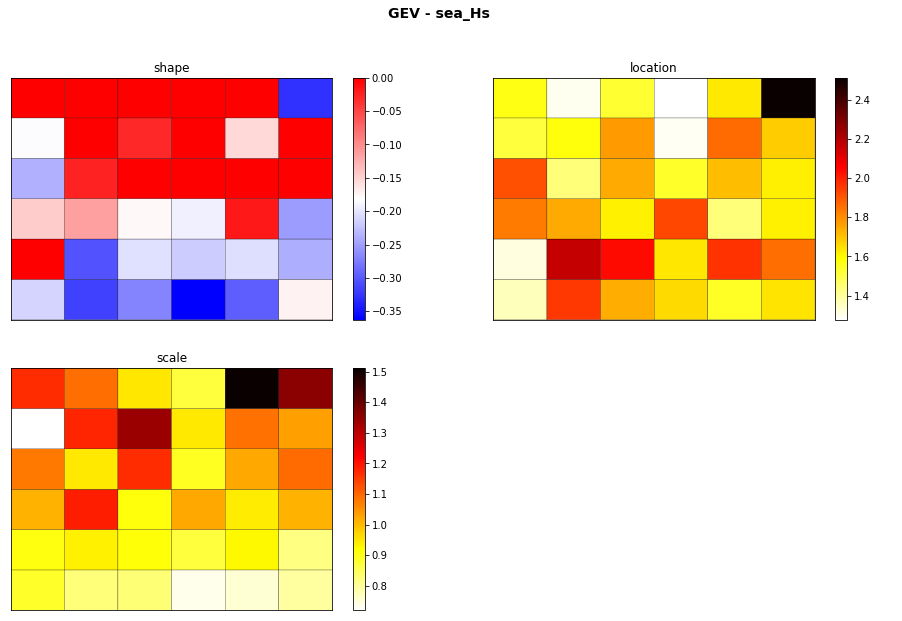

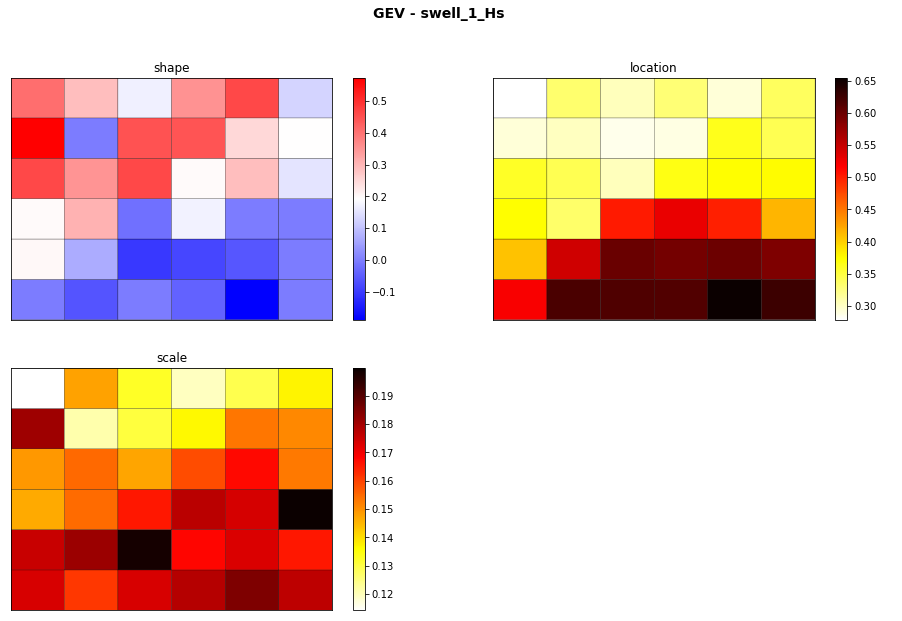

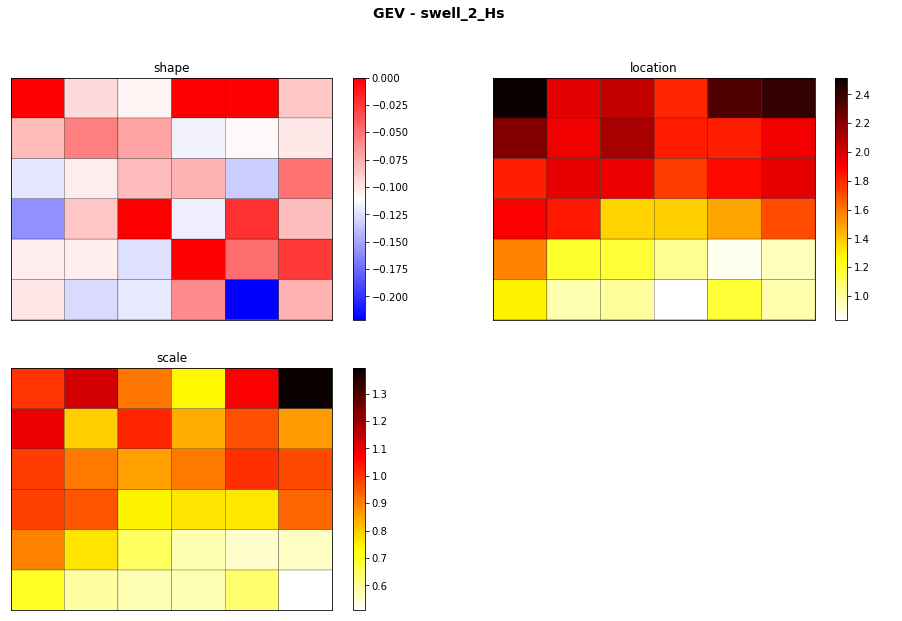

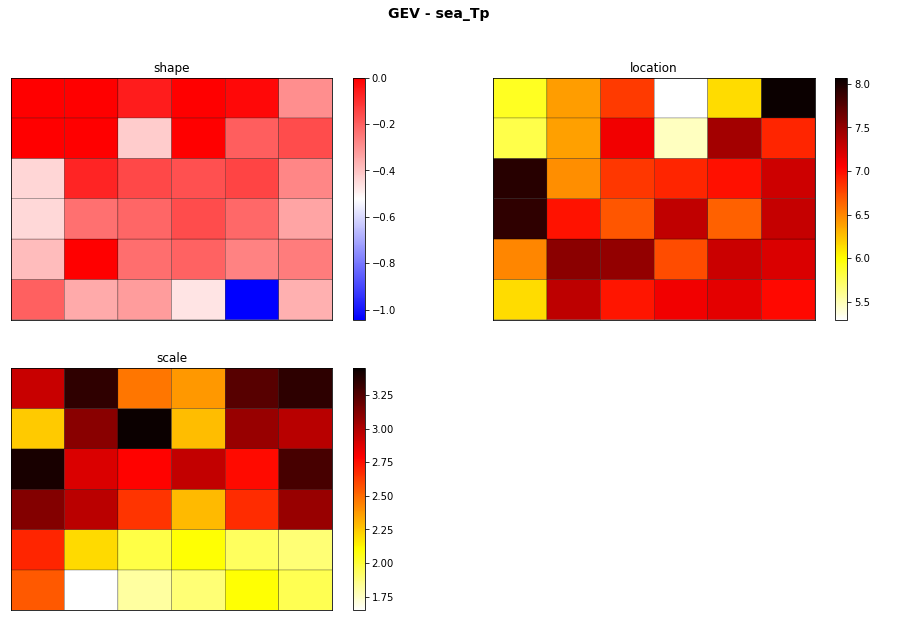

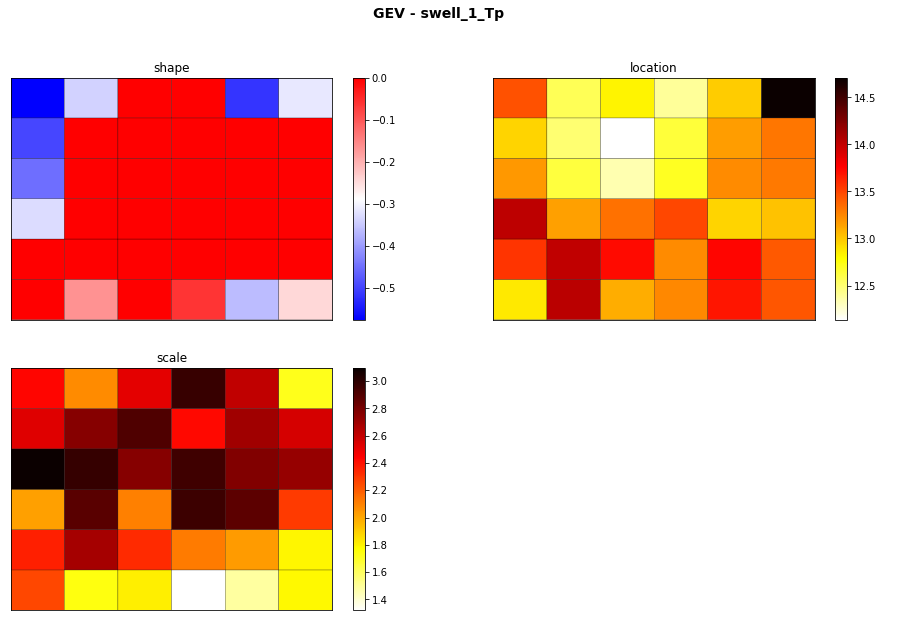

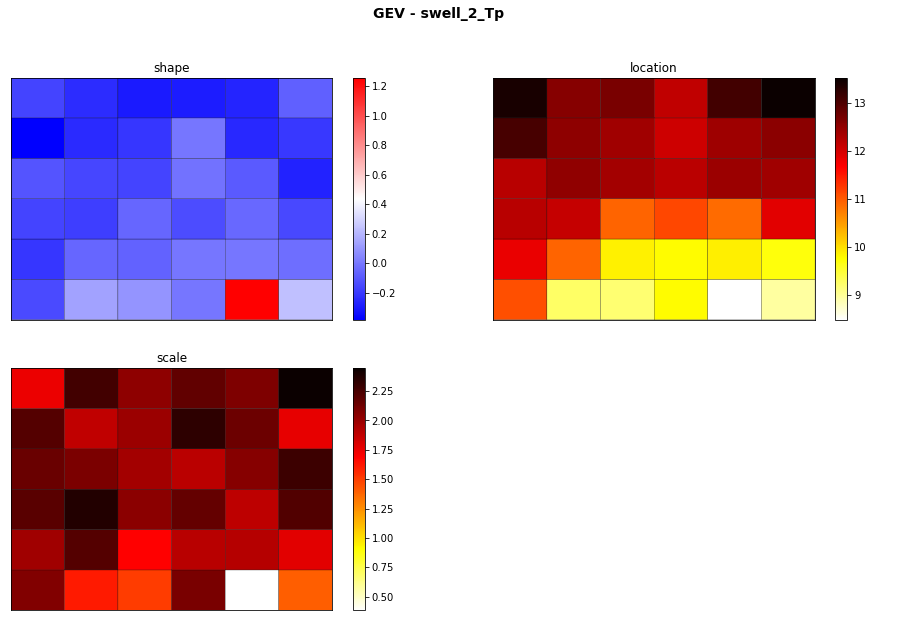

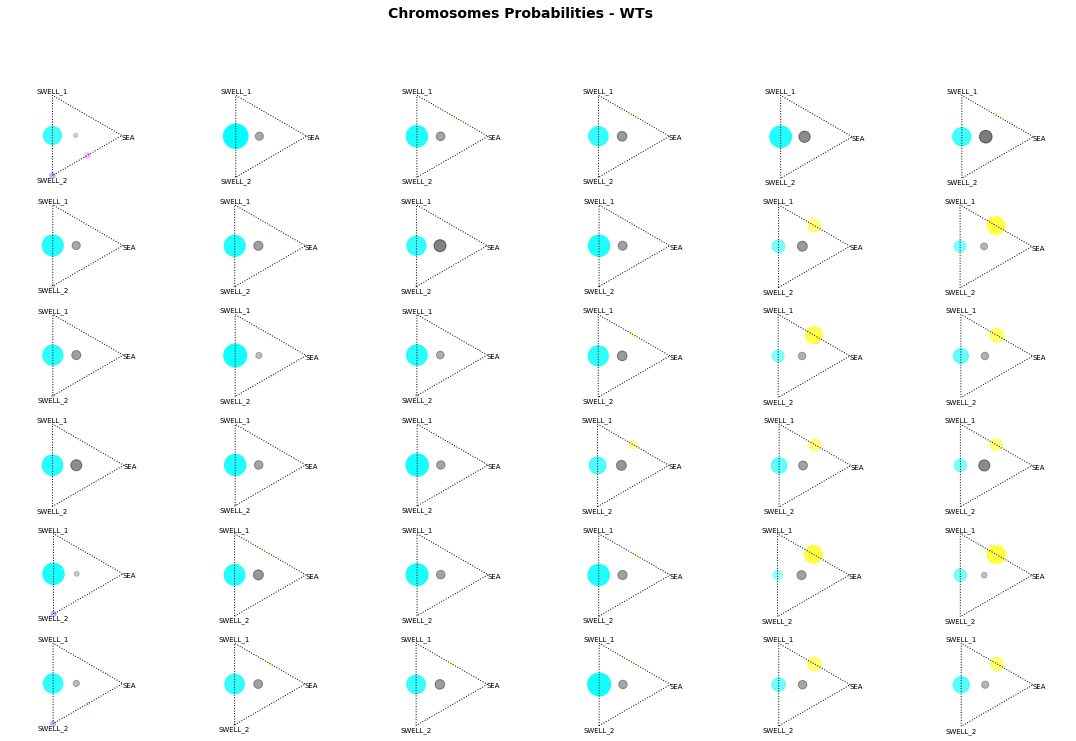

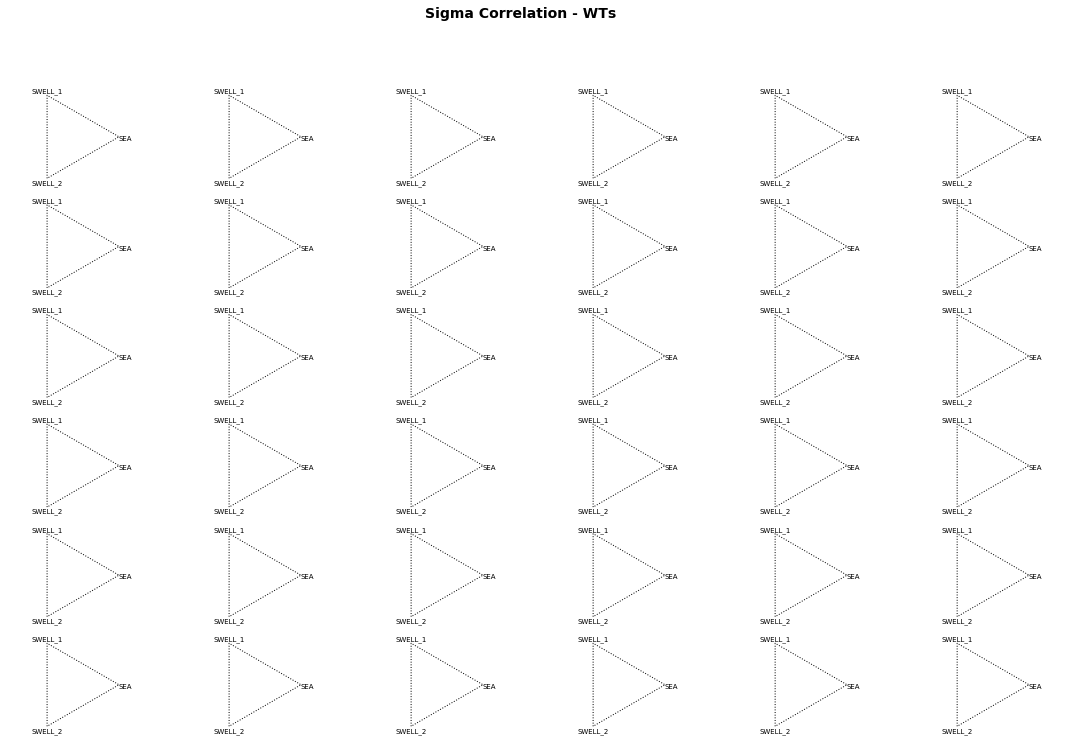

In [9]:
# Fit report figures

CE.Report_Fit(vns_GEV=['Hs', 'Tp'],plot_chrom=True, plot_sigma=True);

# Note: no plots for sigma correlation is OK; correlation has been calculated.


## Climate Emulator - Simulation

In [10]:
# optional: list variables to override distribution to empirical
#CE.sim_icdf_empirical_override = ['swell_2_Hs_31', 'swell_2_Tp_31']

# set simulated waves min-max filter
CE.sim_waves_filter.update({
    'hs': (0, 8),
    'tp': (2, 25),
    'ws': (0, 0.06),
})

In [11]:
# 500 years aprox
DWTs_sim=DWTs_sim.isel(time=range(182987))
DWTs_sim

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 182987)
Coordinates:
  * time         (time) object 2000-06-01 00:00:00 ... 2501-06-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1

### Warning: this code cell below may take several hours to run

In [12]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves

for n in DWTs_sim.n_sim:
    
    print('- Sim: {0} -'.format(int(n)+1))

    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)

    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})

    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)

    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))


- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 80137/80137 [00:00<00:00, 105290.95it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 80129/80129 [00:00<00:00, 95053.63it/s] 


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 80166/80166 [00:00<00:00, 97535.19it/s] 


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 80009/80009 [00:00<00:00, 105706.33it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 80099/80099 [00:00<00:00, 105036.20it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 80213/80213 [00:00<00:00, 104941.98it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 79900/79900 [00:00<00:00, 99559.90it/s] 


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 80202/80202 [00:00<00:00, 101274.11it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 80137/80137 [00:00<00:00, 98044.97it/s] 


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 79953/79953 [00:00<00:00, 96726.66it/s] 



## Climate Emulator Simulation Validation

In [13]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# only one climate emulator simulation
WVS_sim = WVS_sim.isel(n_sim = n_sim_CE)
TCs_sim = TCs_sim.isel(n_sim = n_sim_CE)
WVS_upd = WVS_upd.isel(n_sim = n_sim_CE)


# select data
WVS_fit_p = CE.WVS_MS
WVS_sim_p = WVS_upd  # with simulated TCs
WVS_sim_ev = WVS_sim


## Climate Emulator Validation: Waves Families Variables

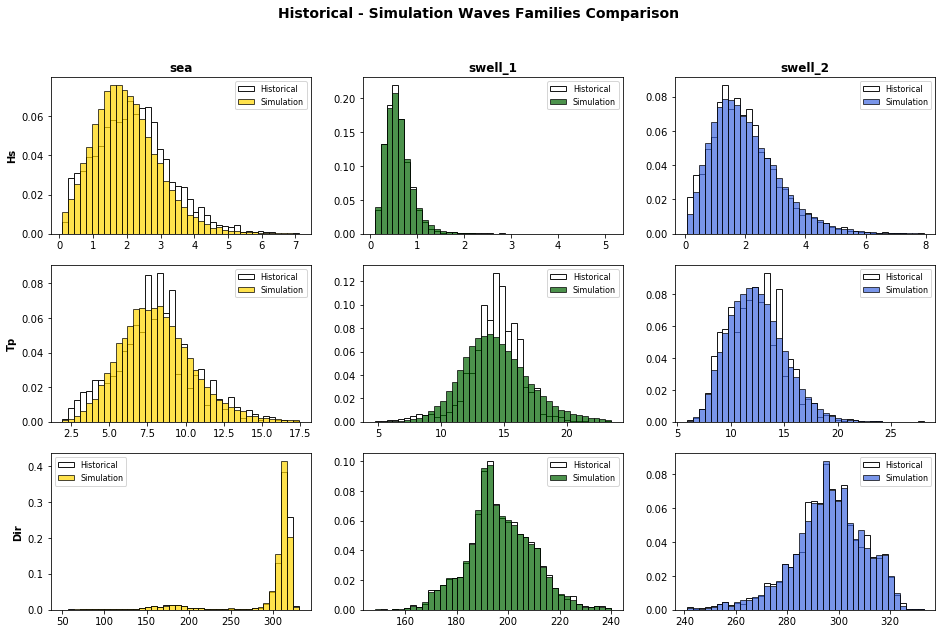

In [14]:
# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit_p, WVS_sim_p);


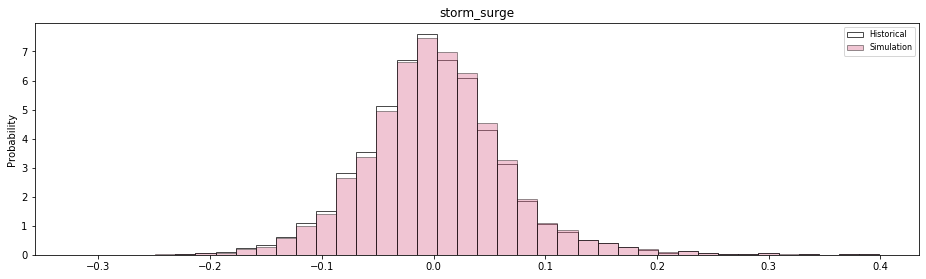

In [15]:
# Plot simulated extra variables (if any)
# extra_vars = ['storm_surge', 'sea_level_pressure', 'wind_u', 'wind_v']  # example
extra_vars = ['storm_surge']  # example
Plot_FitSim_Histograms(
   WVS_fit_p, WVS_sim_ev, extra_vars, density=True,
   color_1='white', color_2='palevioletred',
);


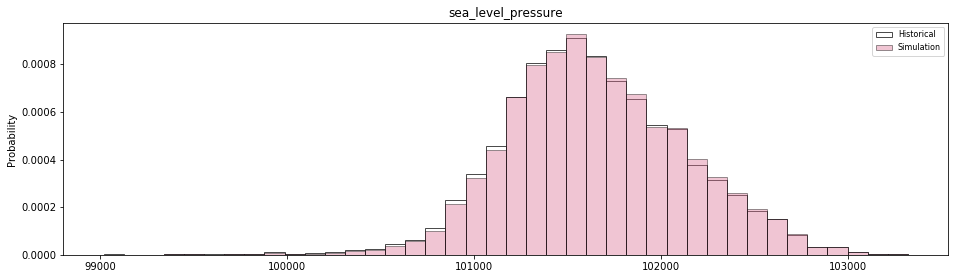

In [16]:
# Plot simulated extra variables (if any)
extra_vars = ['sea_level_pressure']  # example

Plot_FitSim_Histograms(
   WVS_fit_p, WVS_sim_ev, extra_vars, density=True,
   color_1='white', color_2='palevioletred',
);


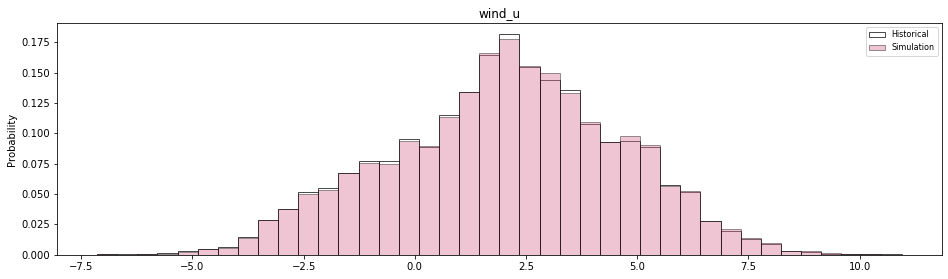

In [17]:
# Plot simulated extra variables (if any)
extra_vars = ['wind_u']  # example

Plot_FitSim_Histograms(
   WVS_fit_p, WVS_sim_ev, extra_vars, density=True,
   color_1='white', color_2='palevioletred',
);


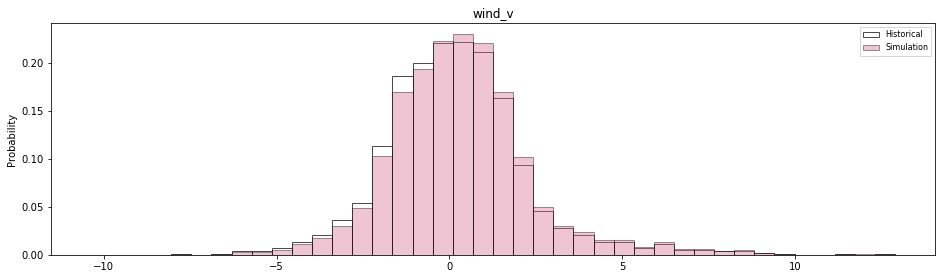

In [18]:
# Plot simulated extra variables (if any)
extra_vars = ['wind_v']  # example

Plot_FitSim_Histograms(
   WVS_fit_p, WVS_sim_ev, extra_vars, density=True,
   color_1='white', color_2='palevioletred',
);



## Climate Emulator Validation: Hs families

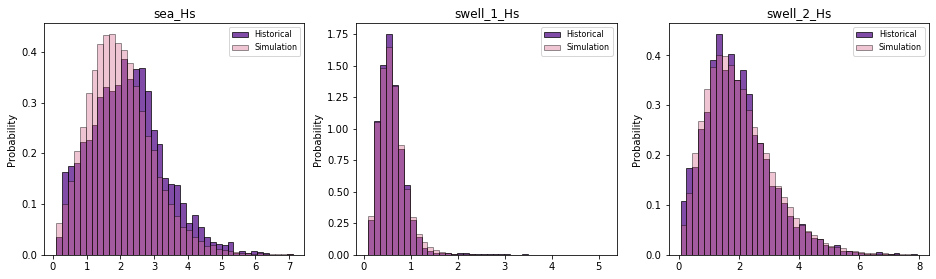

In [19]:
# waves families Hs
vvs = ['sea_Hs', 'swell_1_Hs', 'swell_2_Hs']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


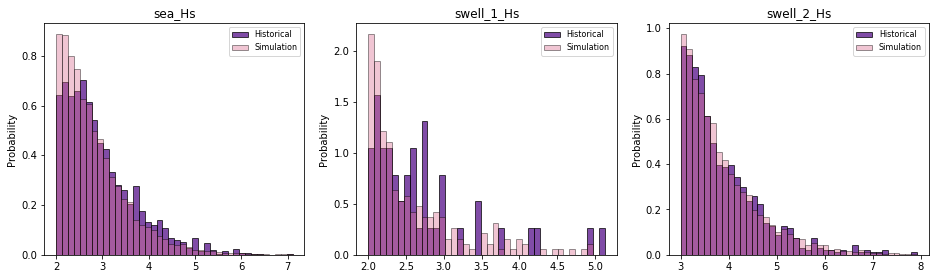

In [20]:
# plot selection
vns_lims = {
    'sea_Hs':(2, 30),
    'swell_1_Hs':(2, 30),
    'swell_2_Hs':(3, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


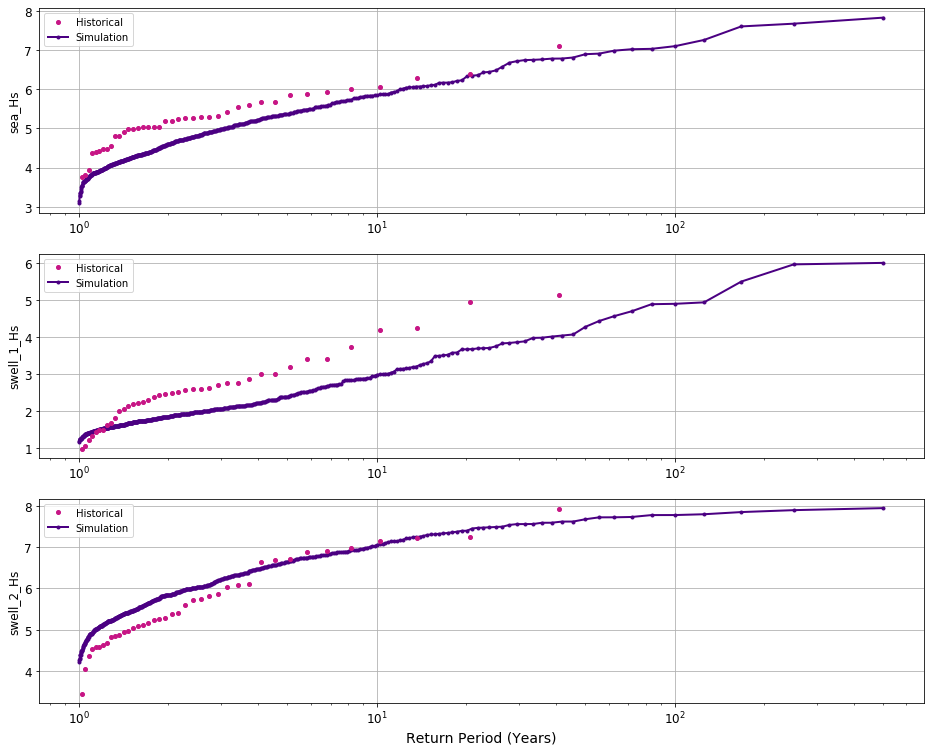

In [21]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


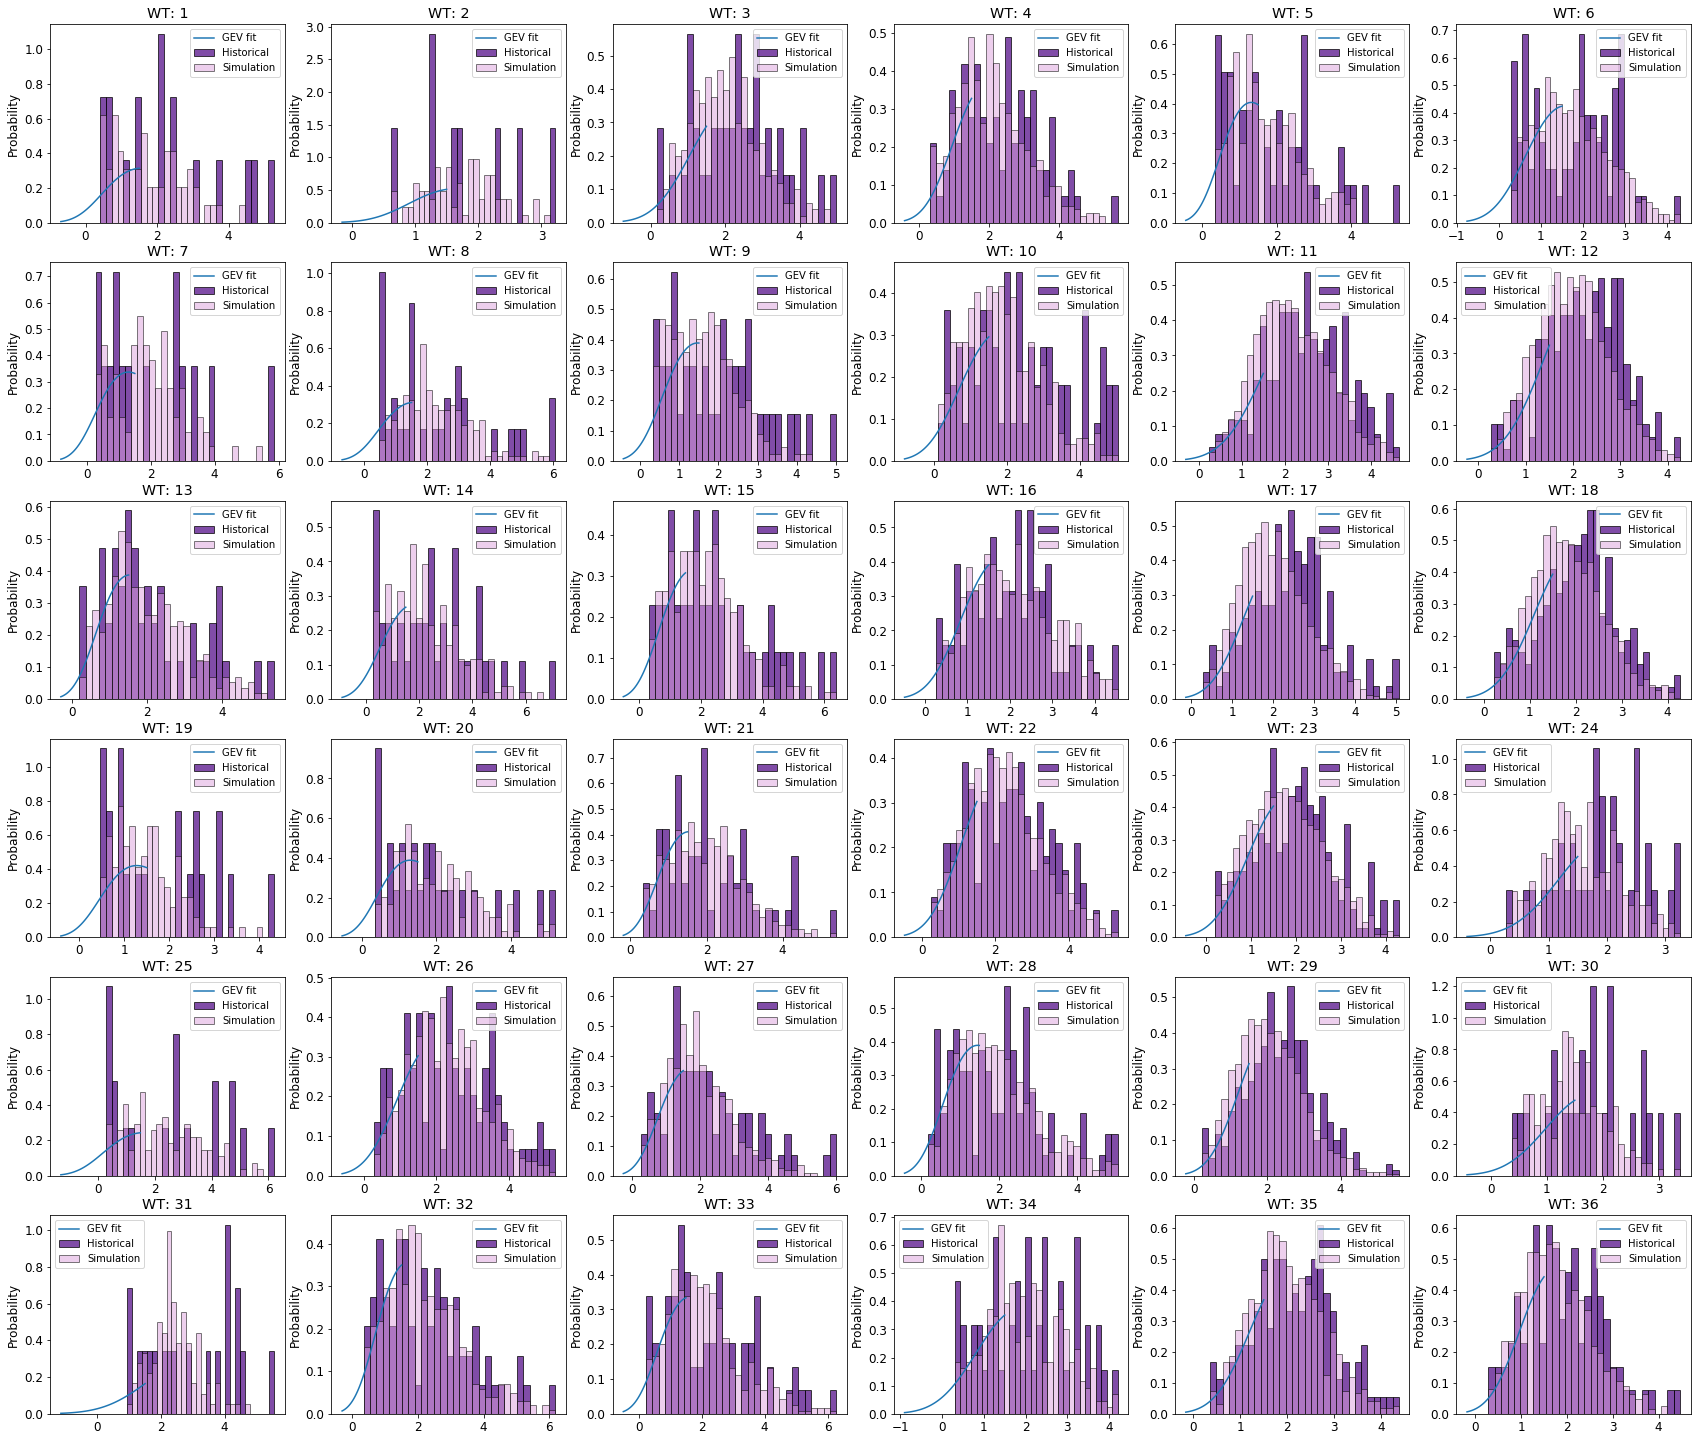

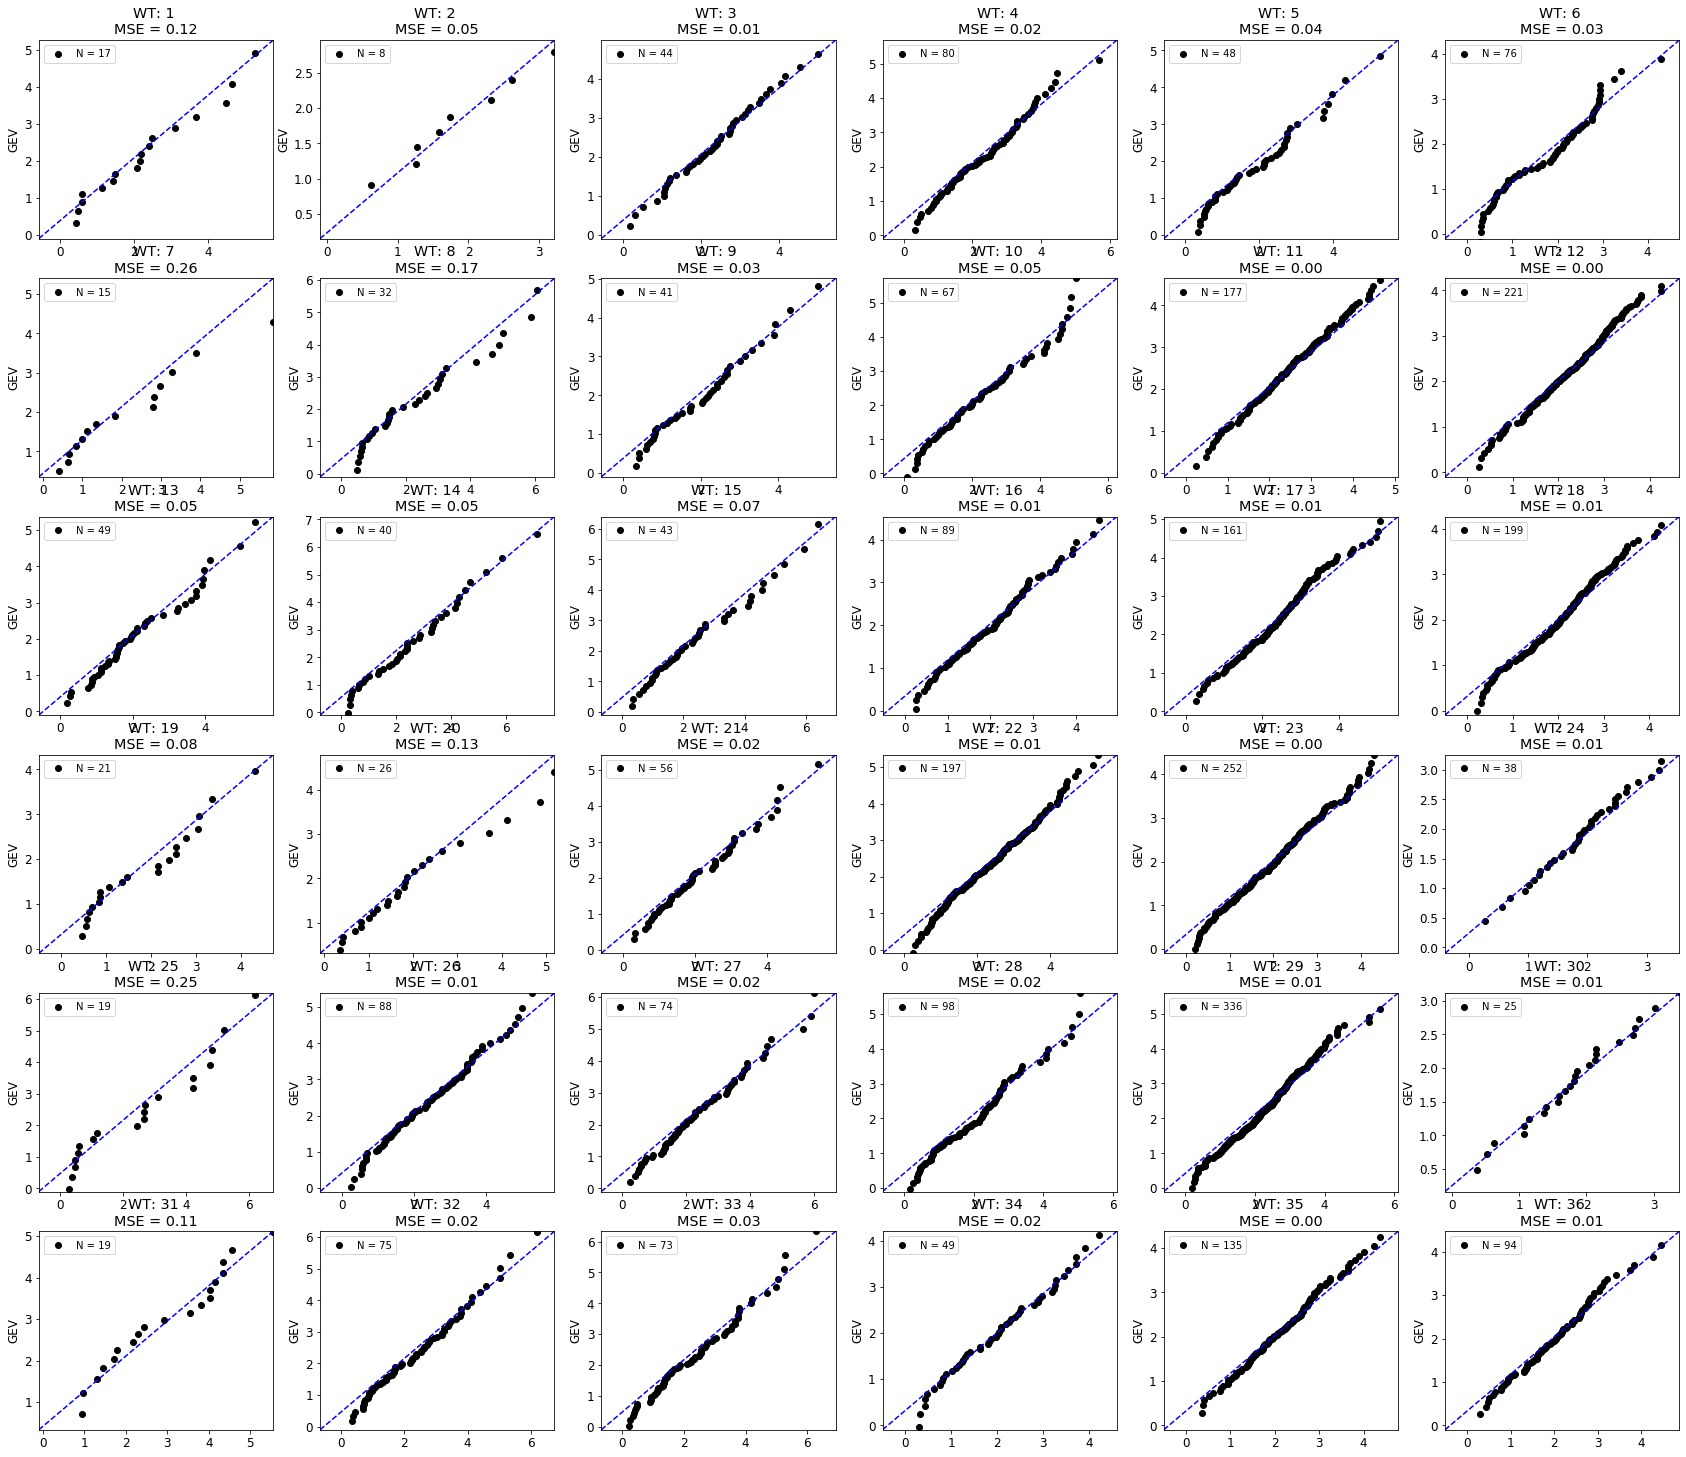

In [22]:
# GEV fit - sim comparison and QQ plot

Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=1.5,
);

Plot_Fit_QQ(
    WVS_fit_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);



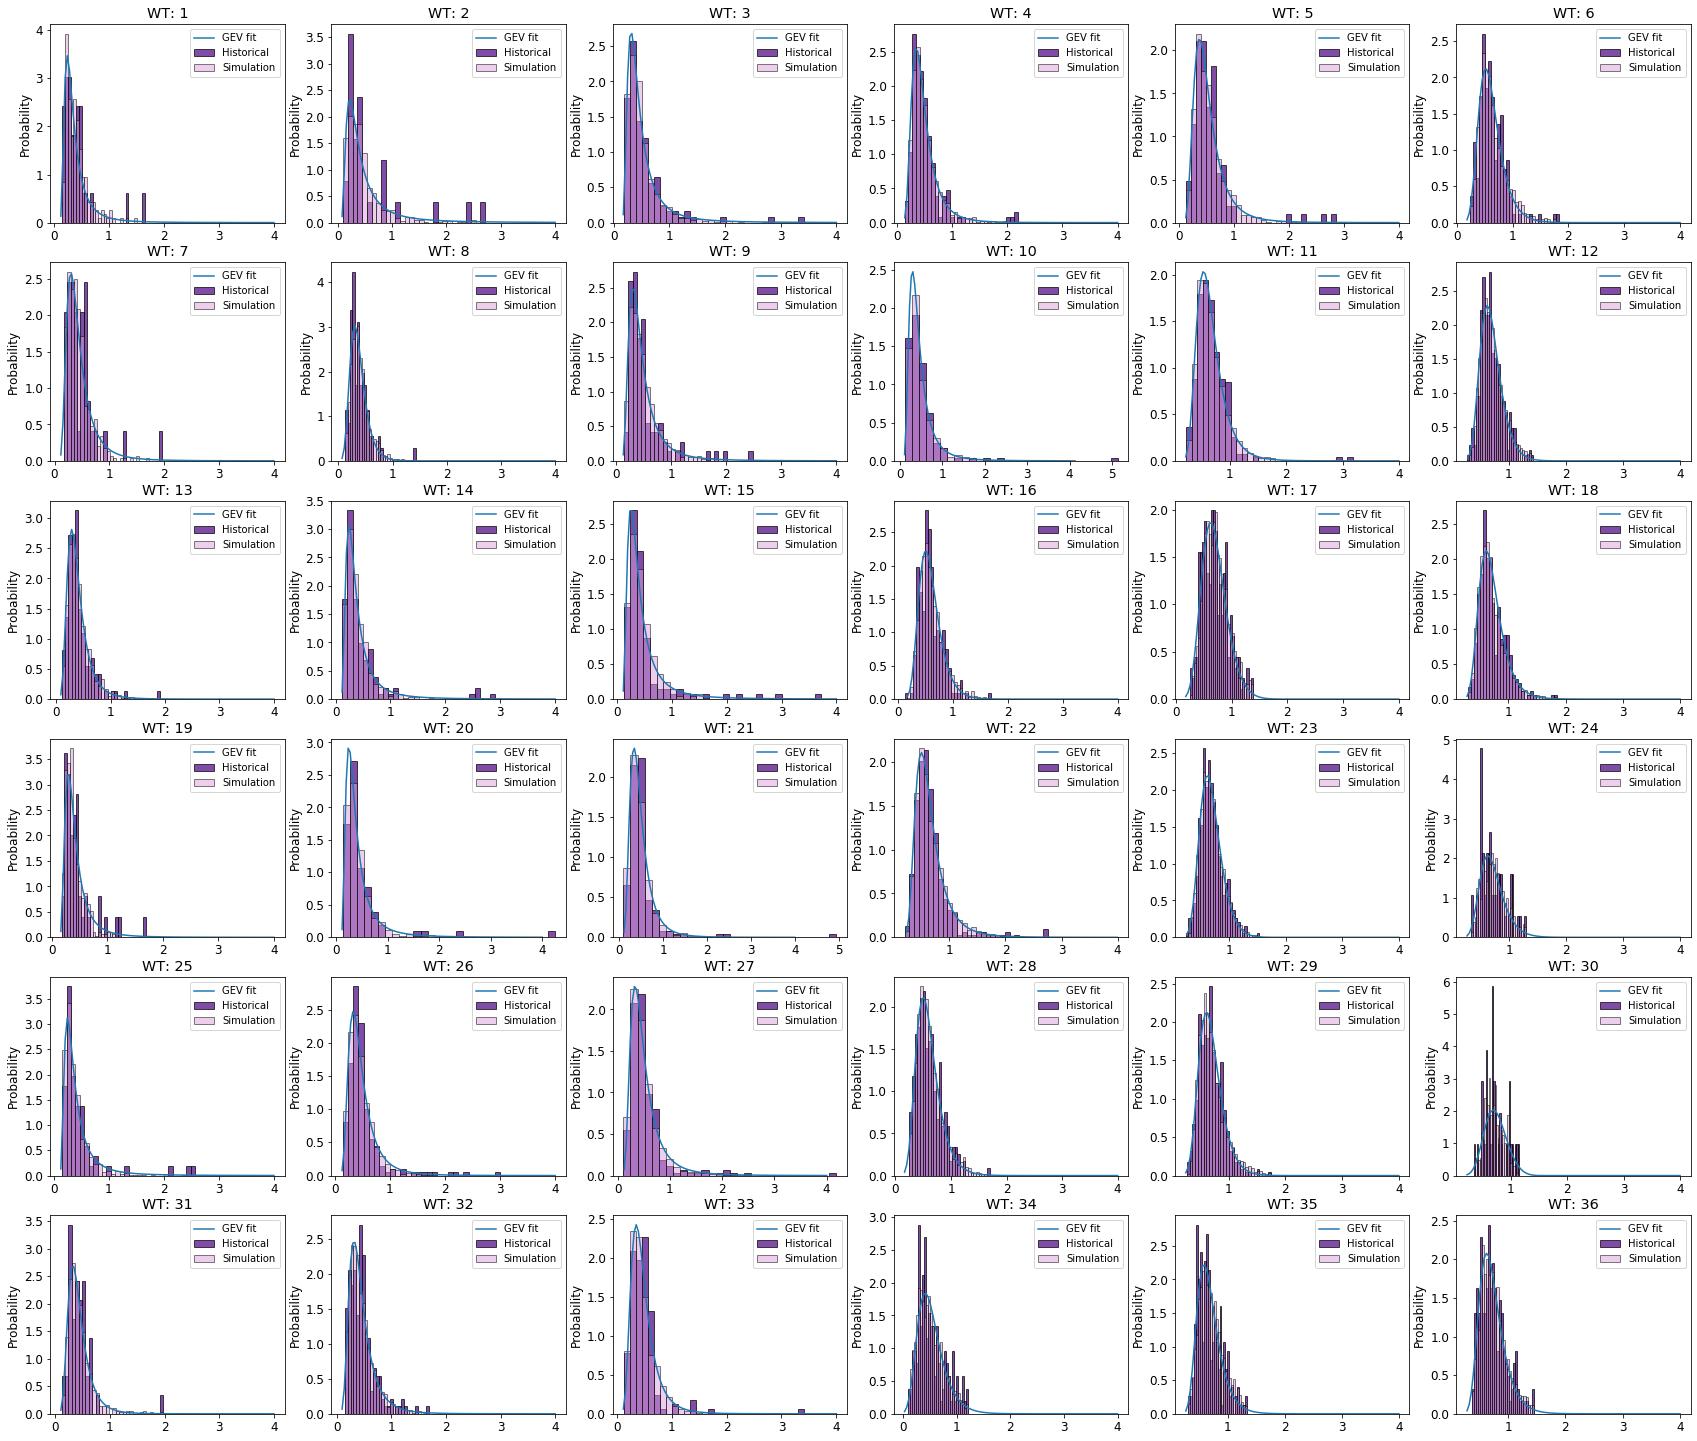

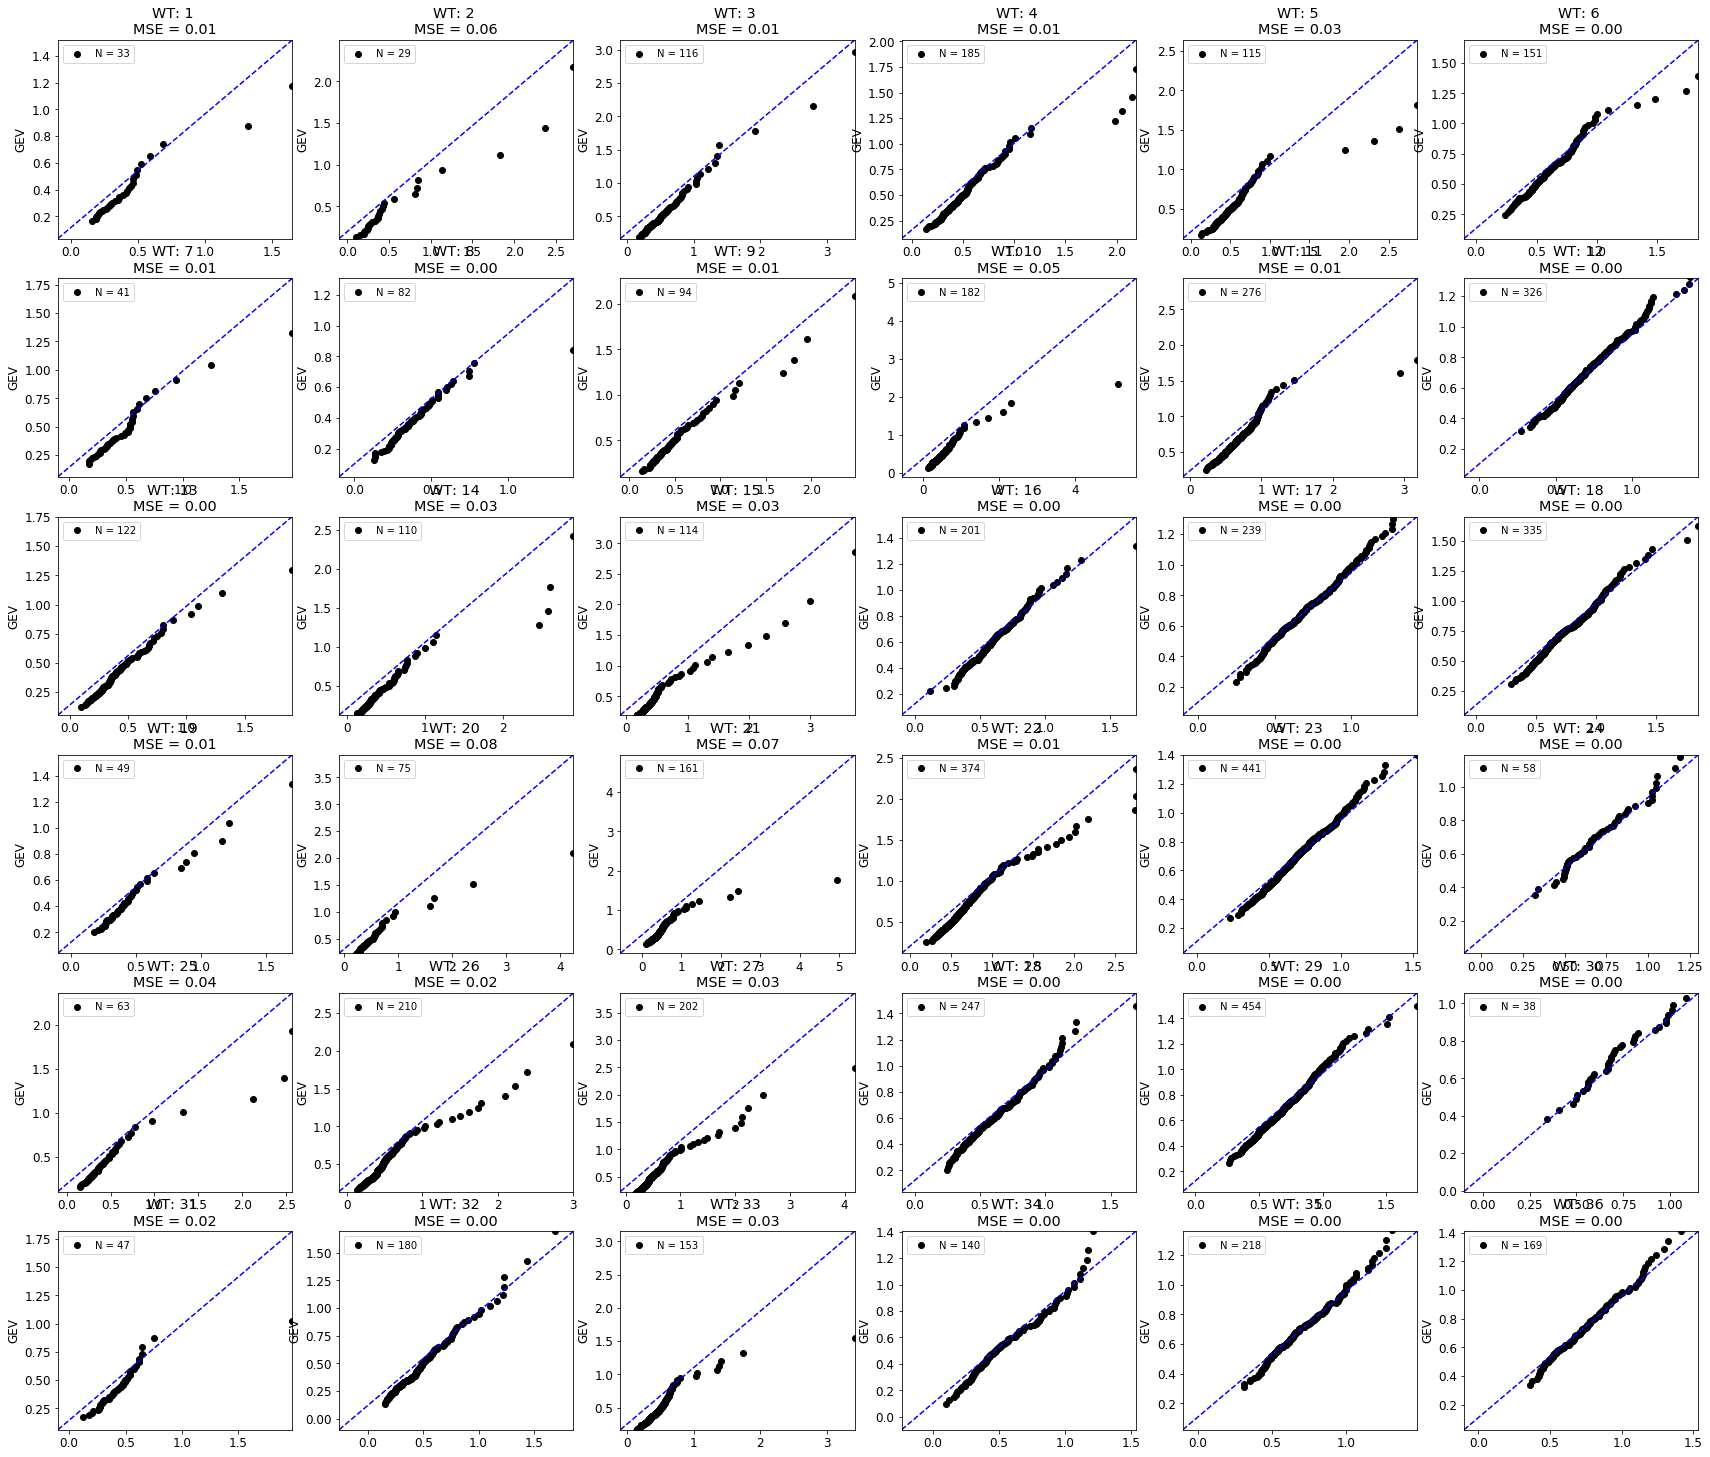

In [23]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


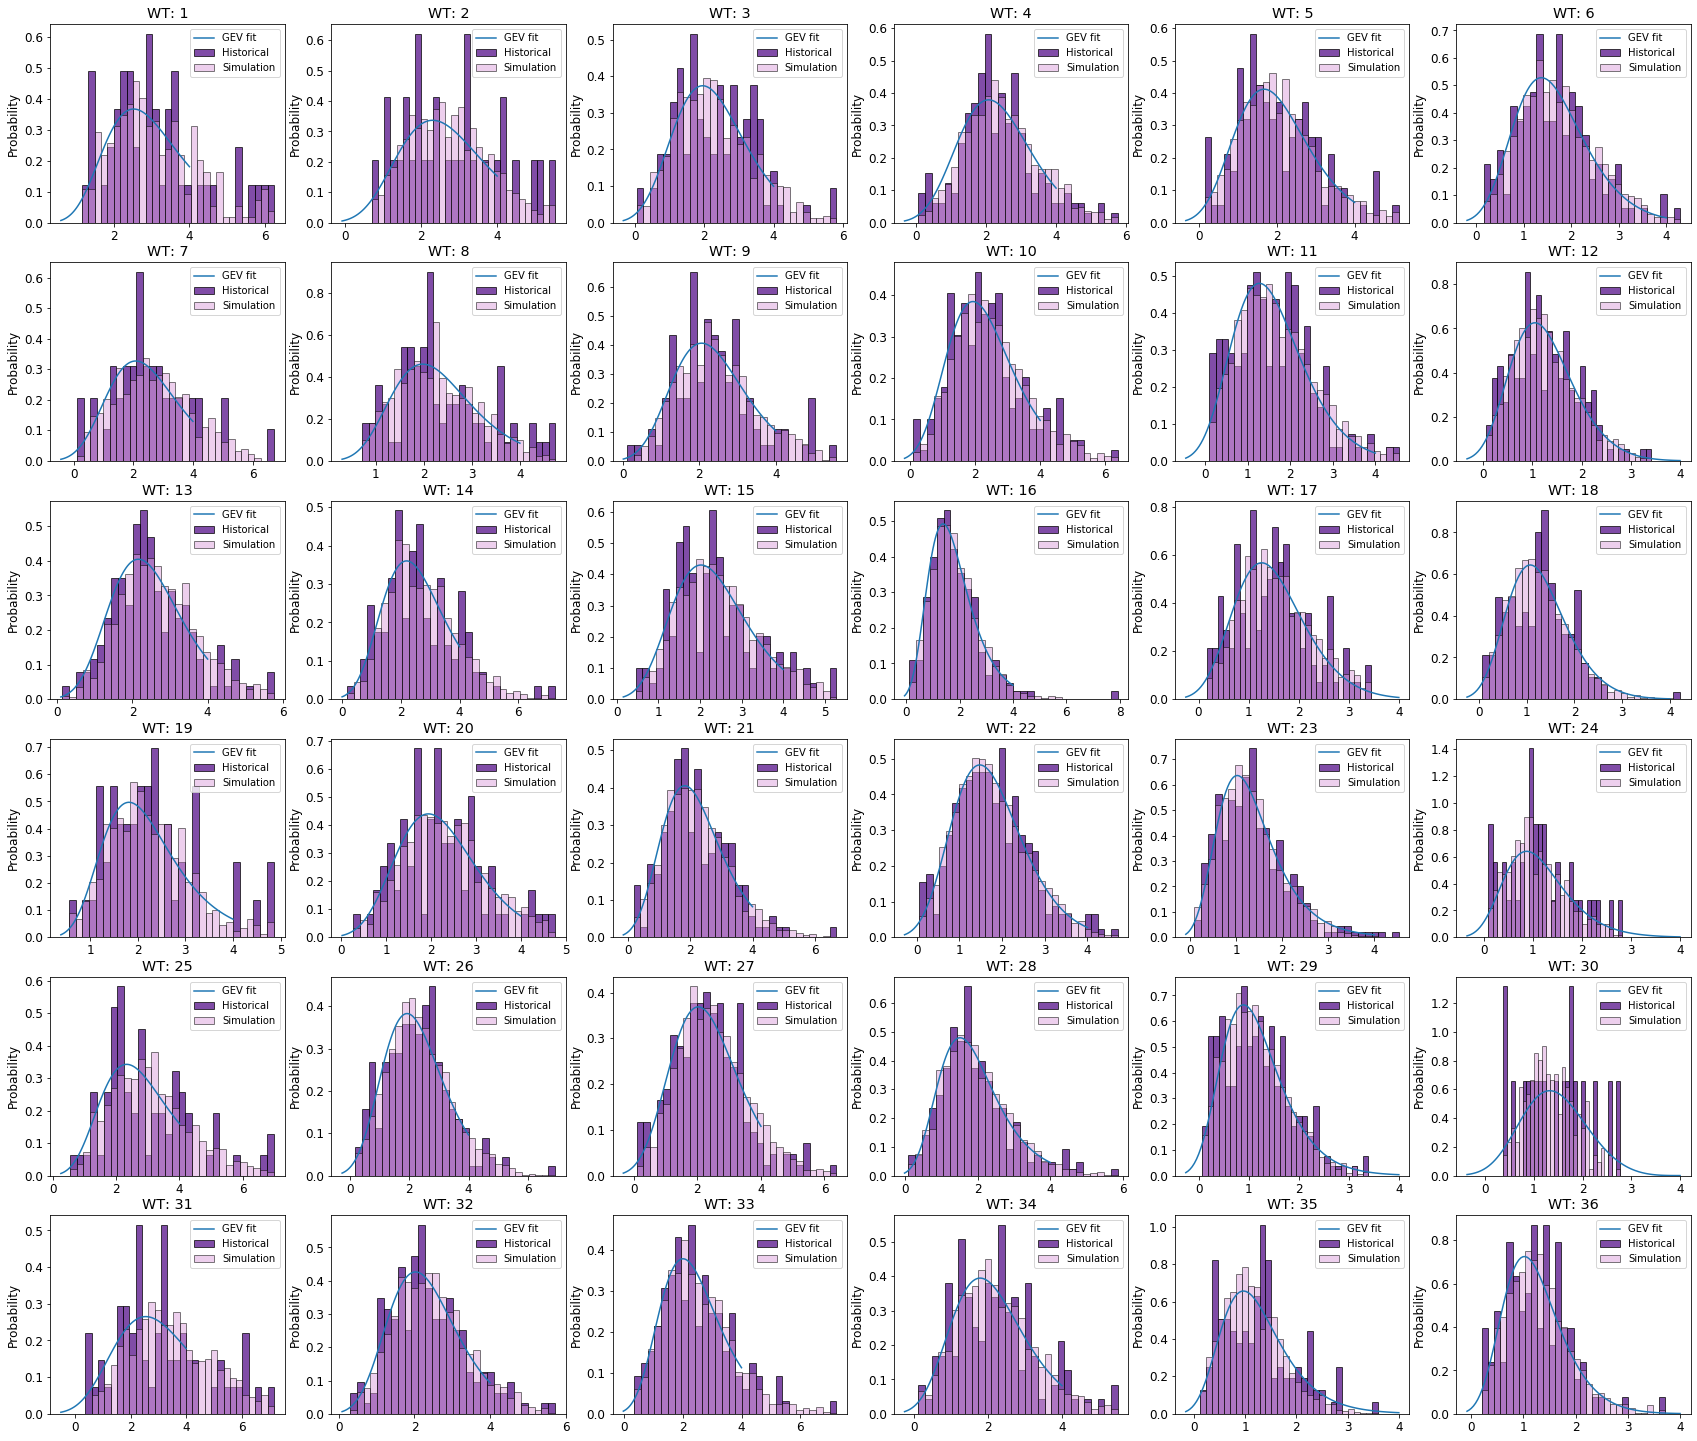

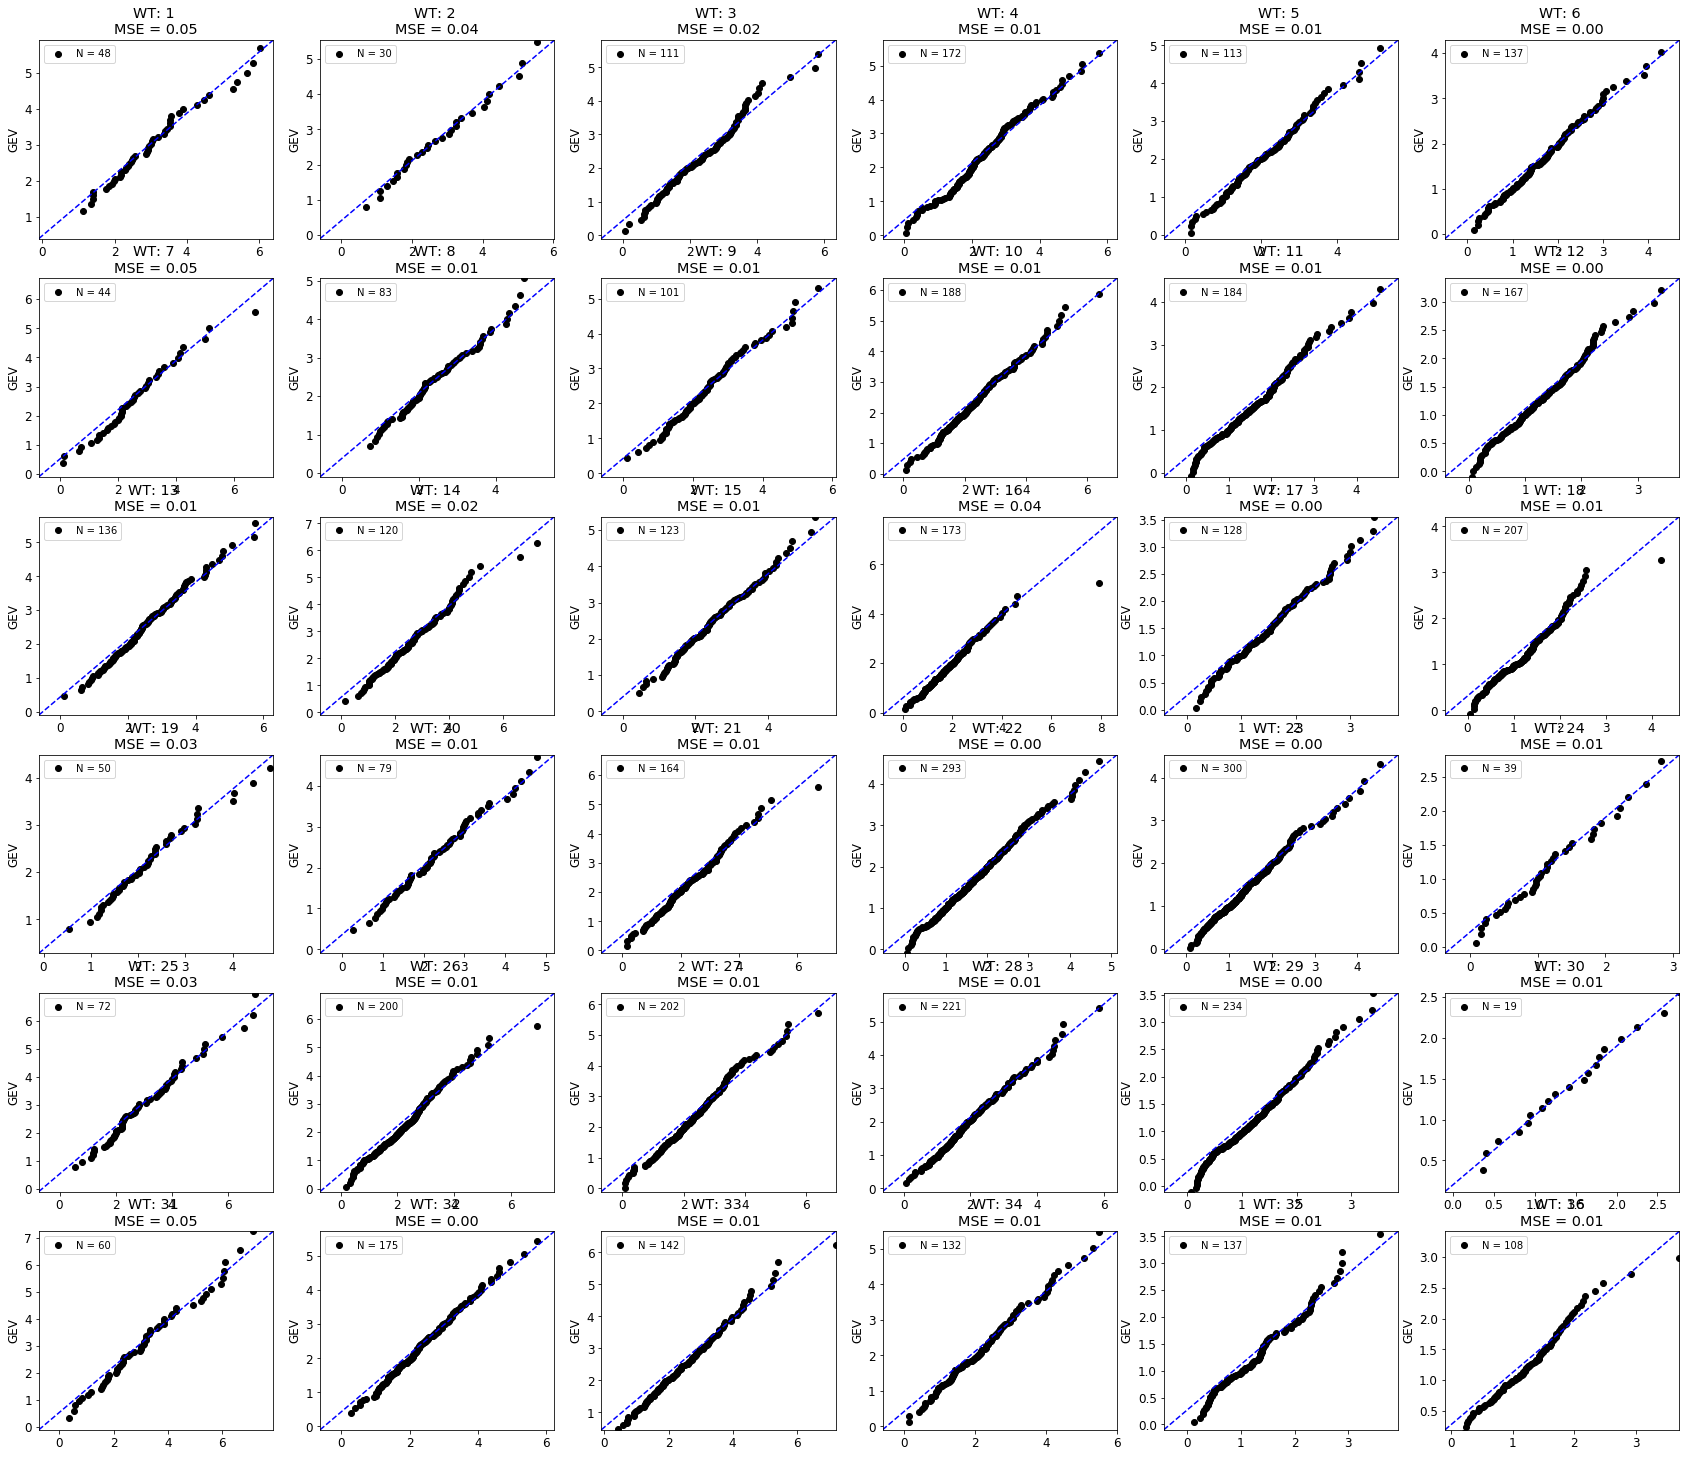

In [24]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);



## Climate Emulator Validation: Tp families

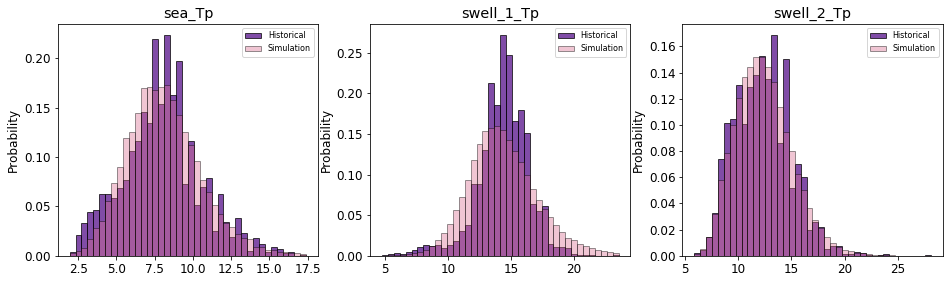

In [25]:
# waves families Tp
vvs = ['sea_Tp', 'swell_1_Tp', 'swell_2_Tp']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


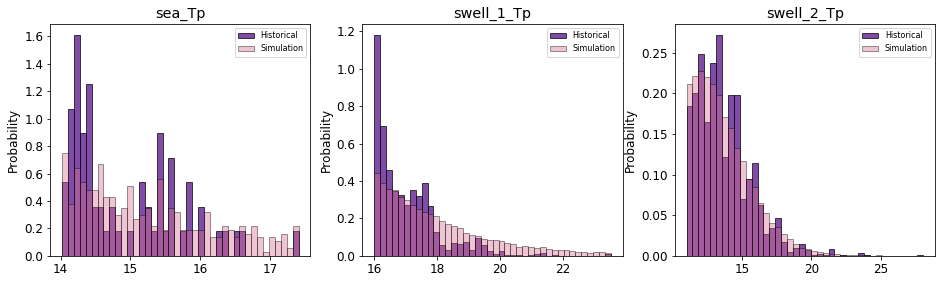

In [26]:
# plot selection
vns_lims = {
    'sea_Tp':(14, 30),
    'swell_1_Tp':(16, 30),
    'swell_2_Tp':(11, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


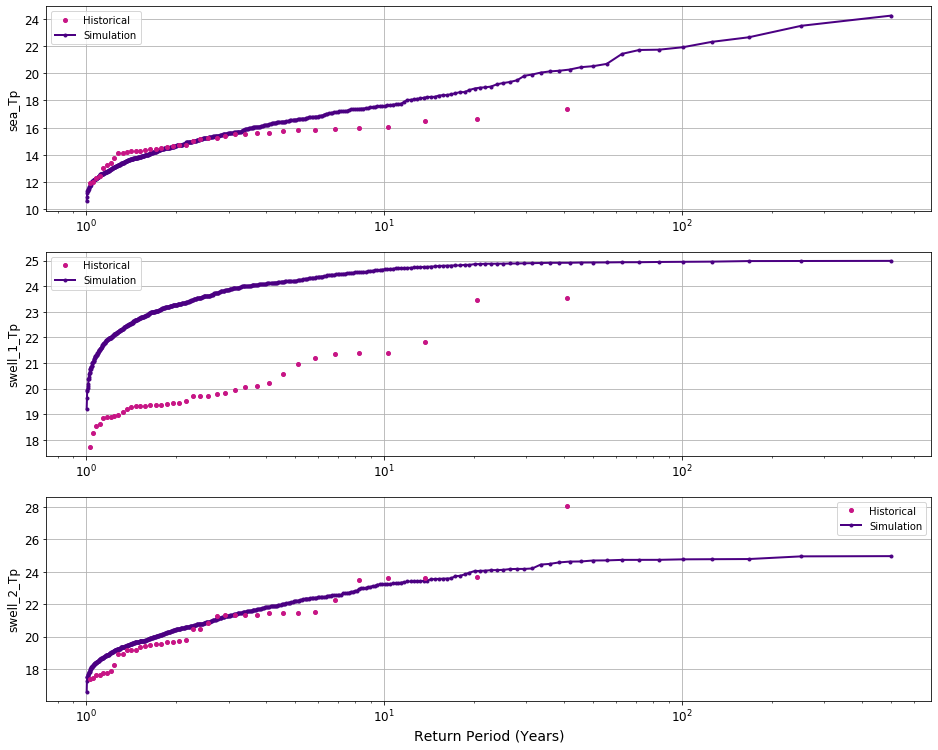

In [27]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


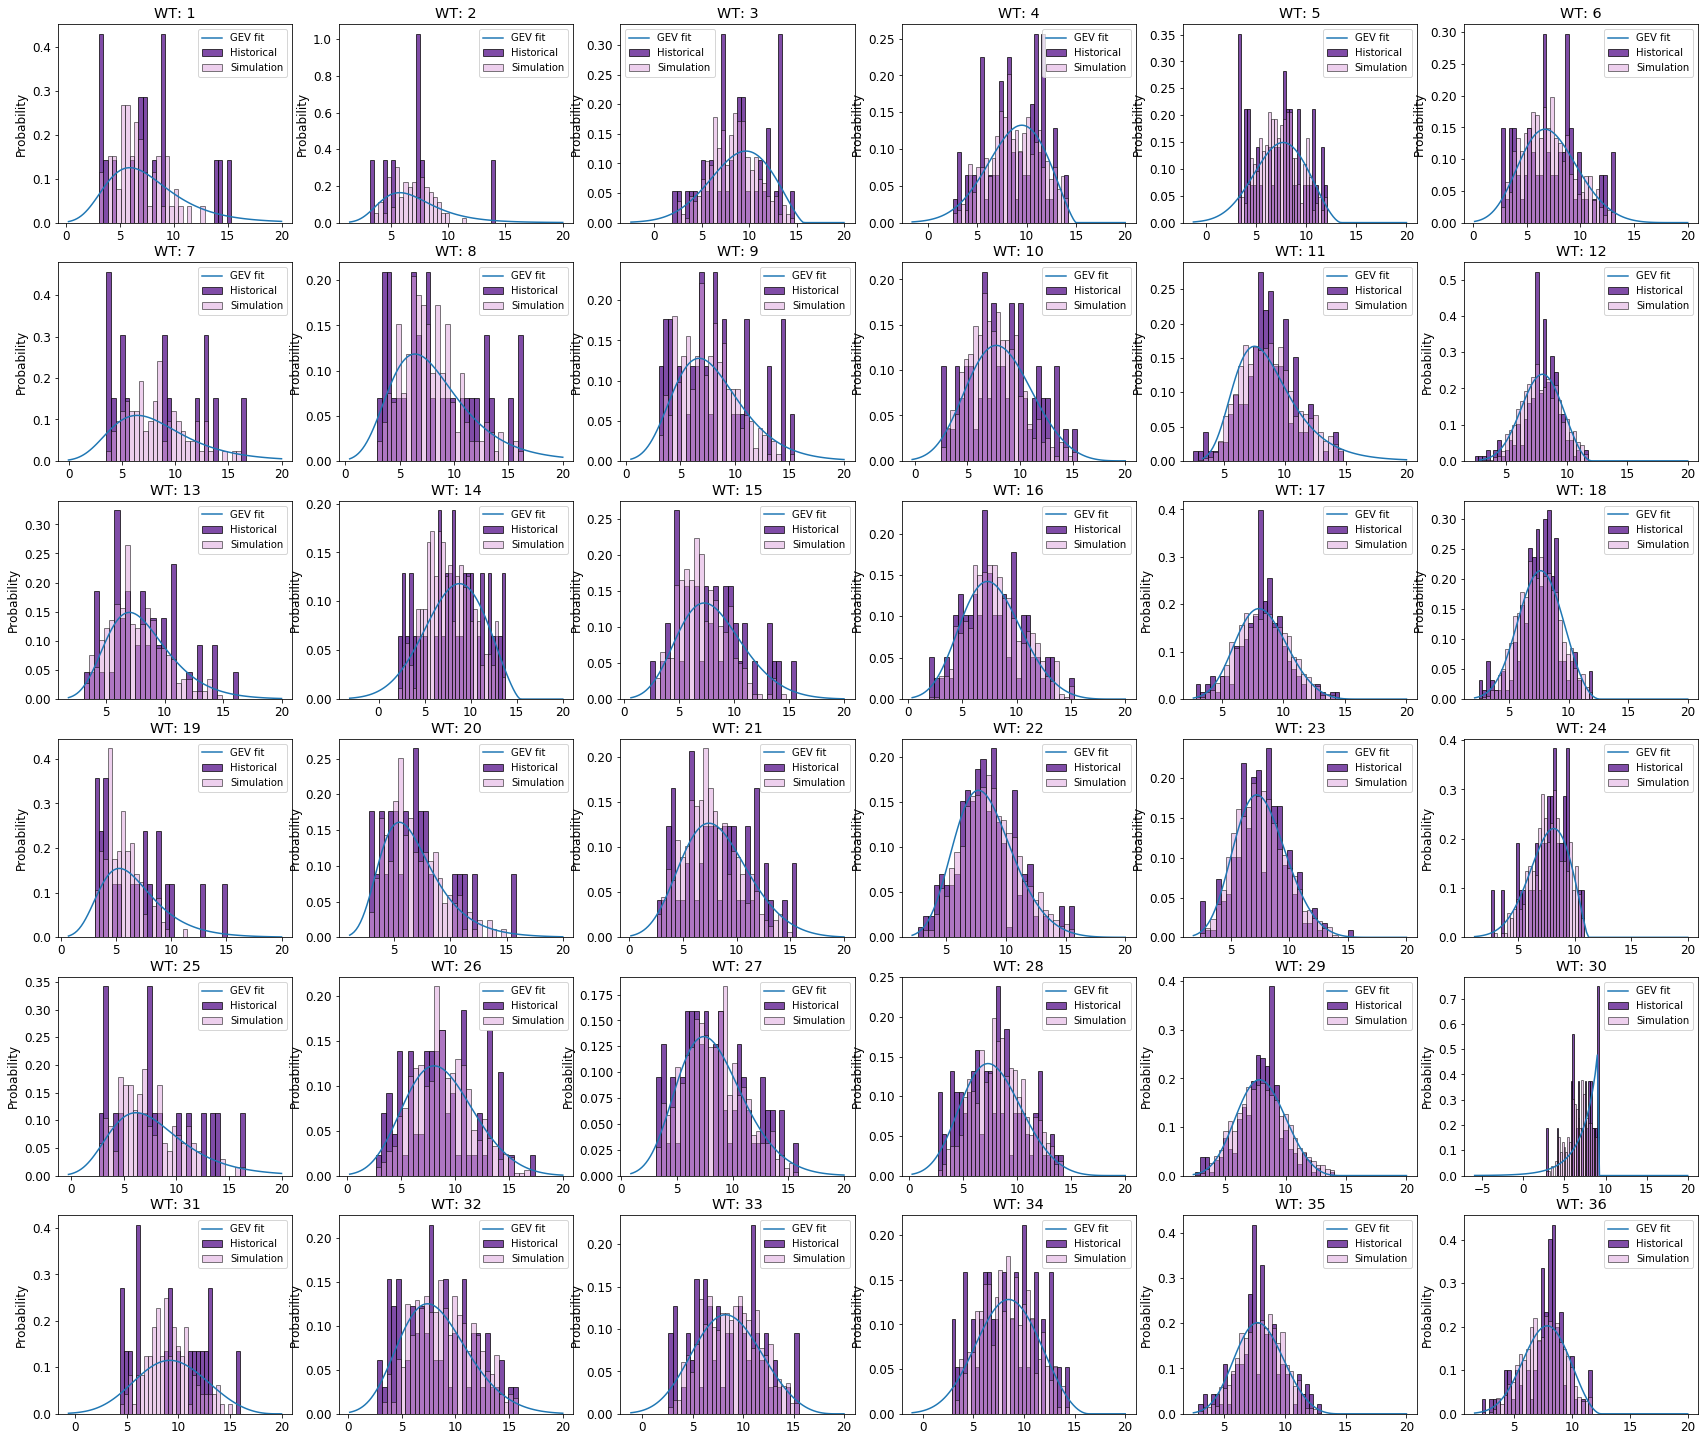

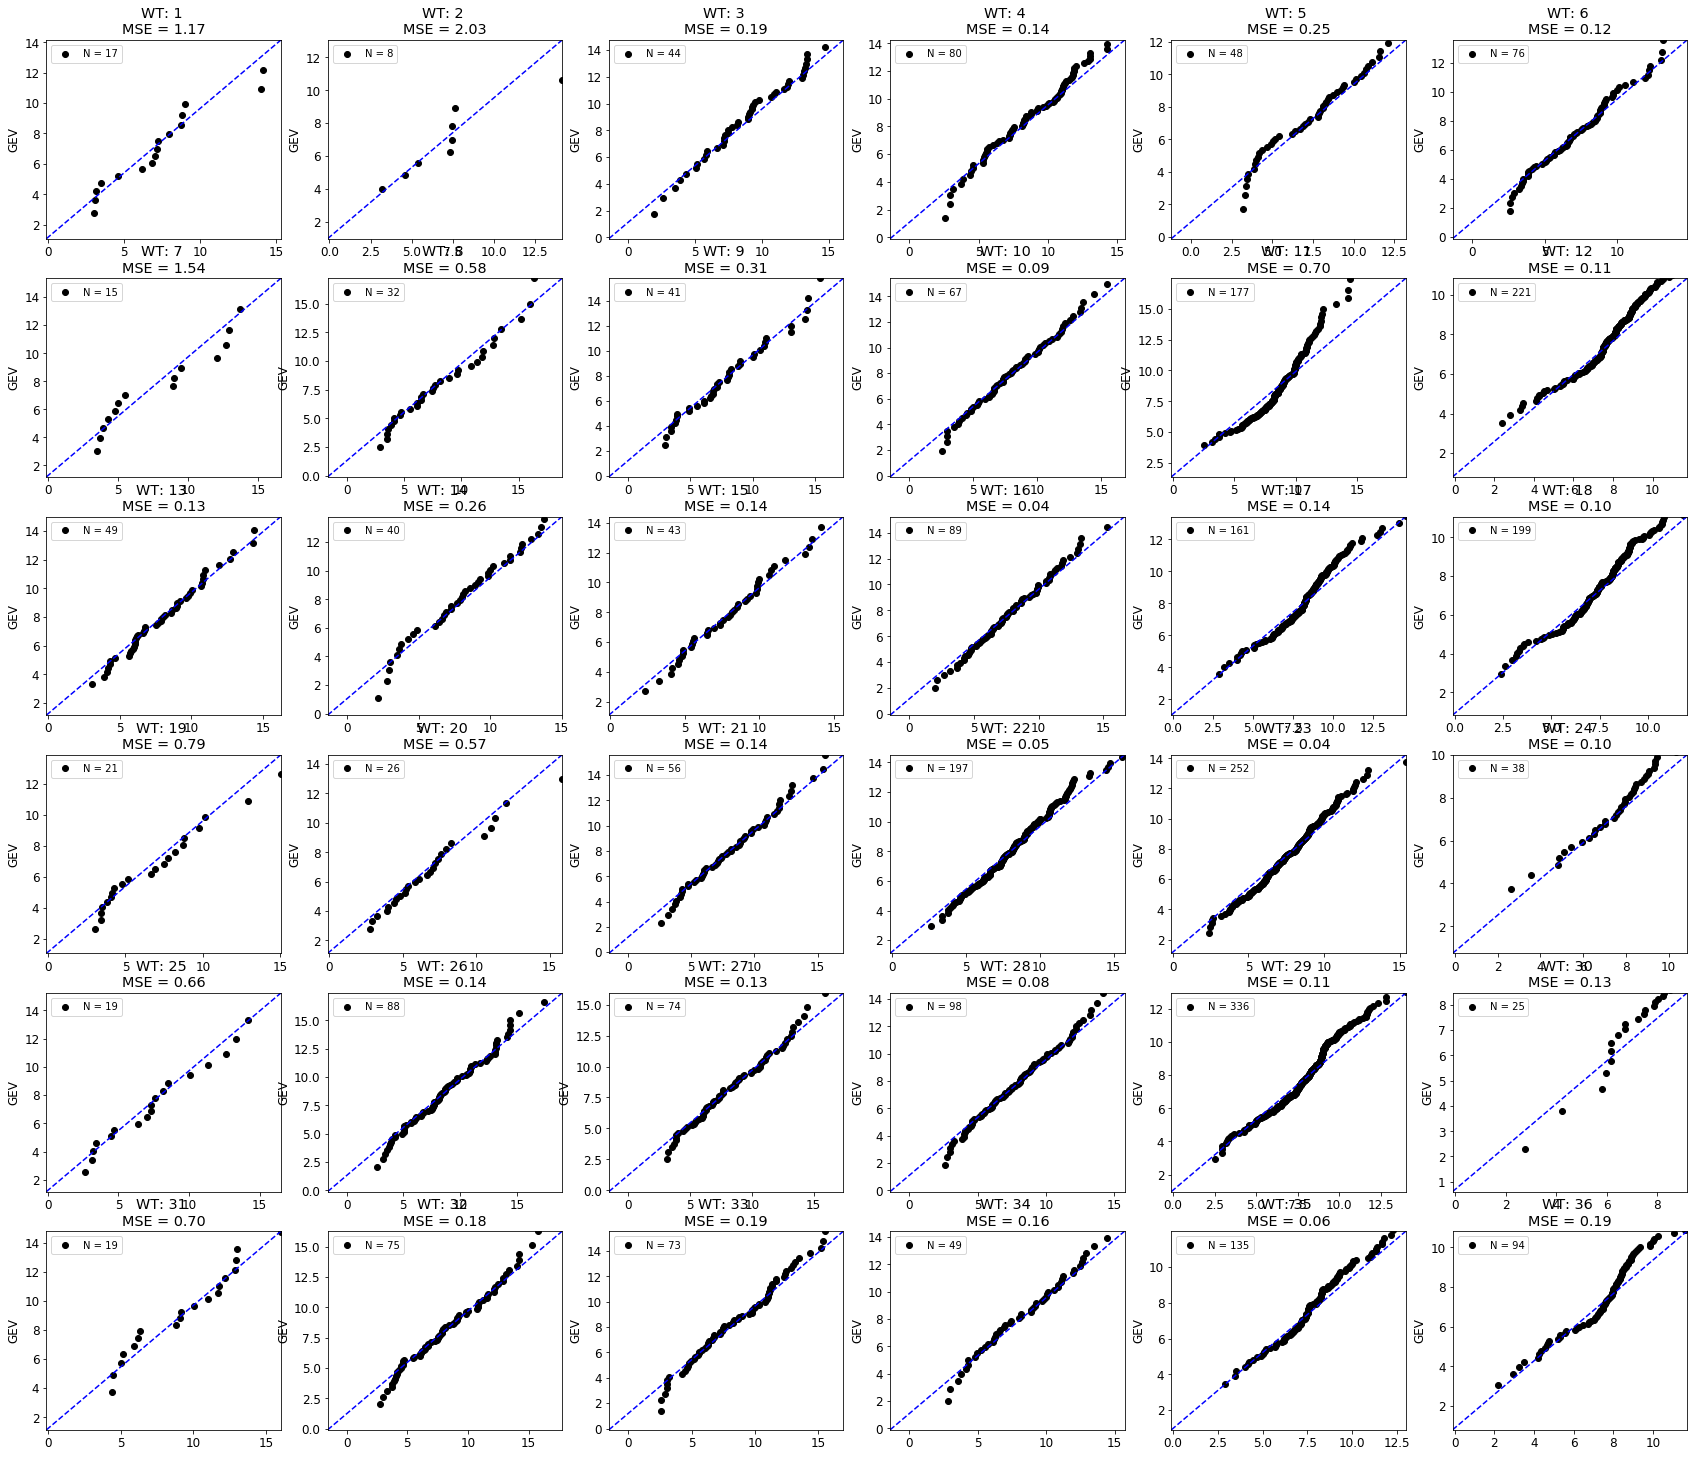

In [28]:
# GEV fit comparison
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'sea_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'sea_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);

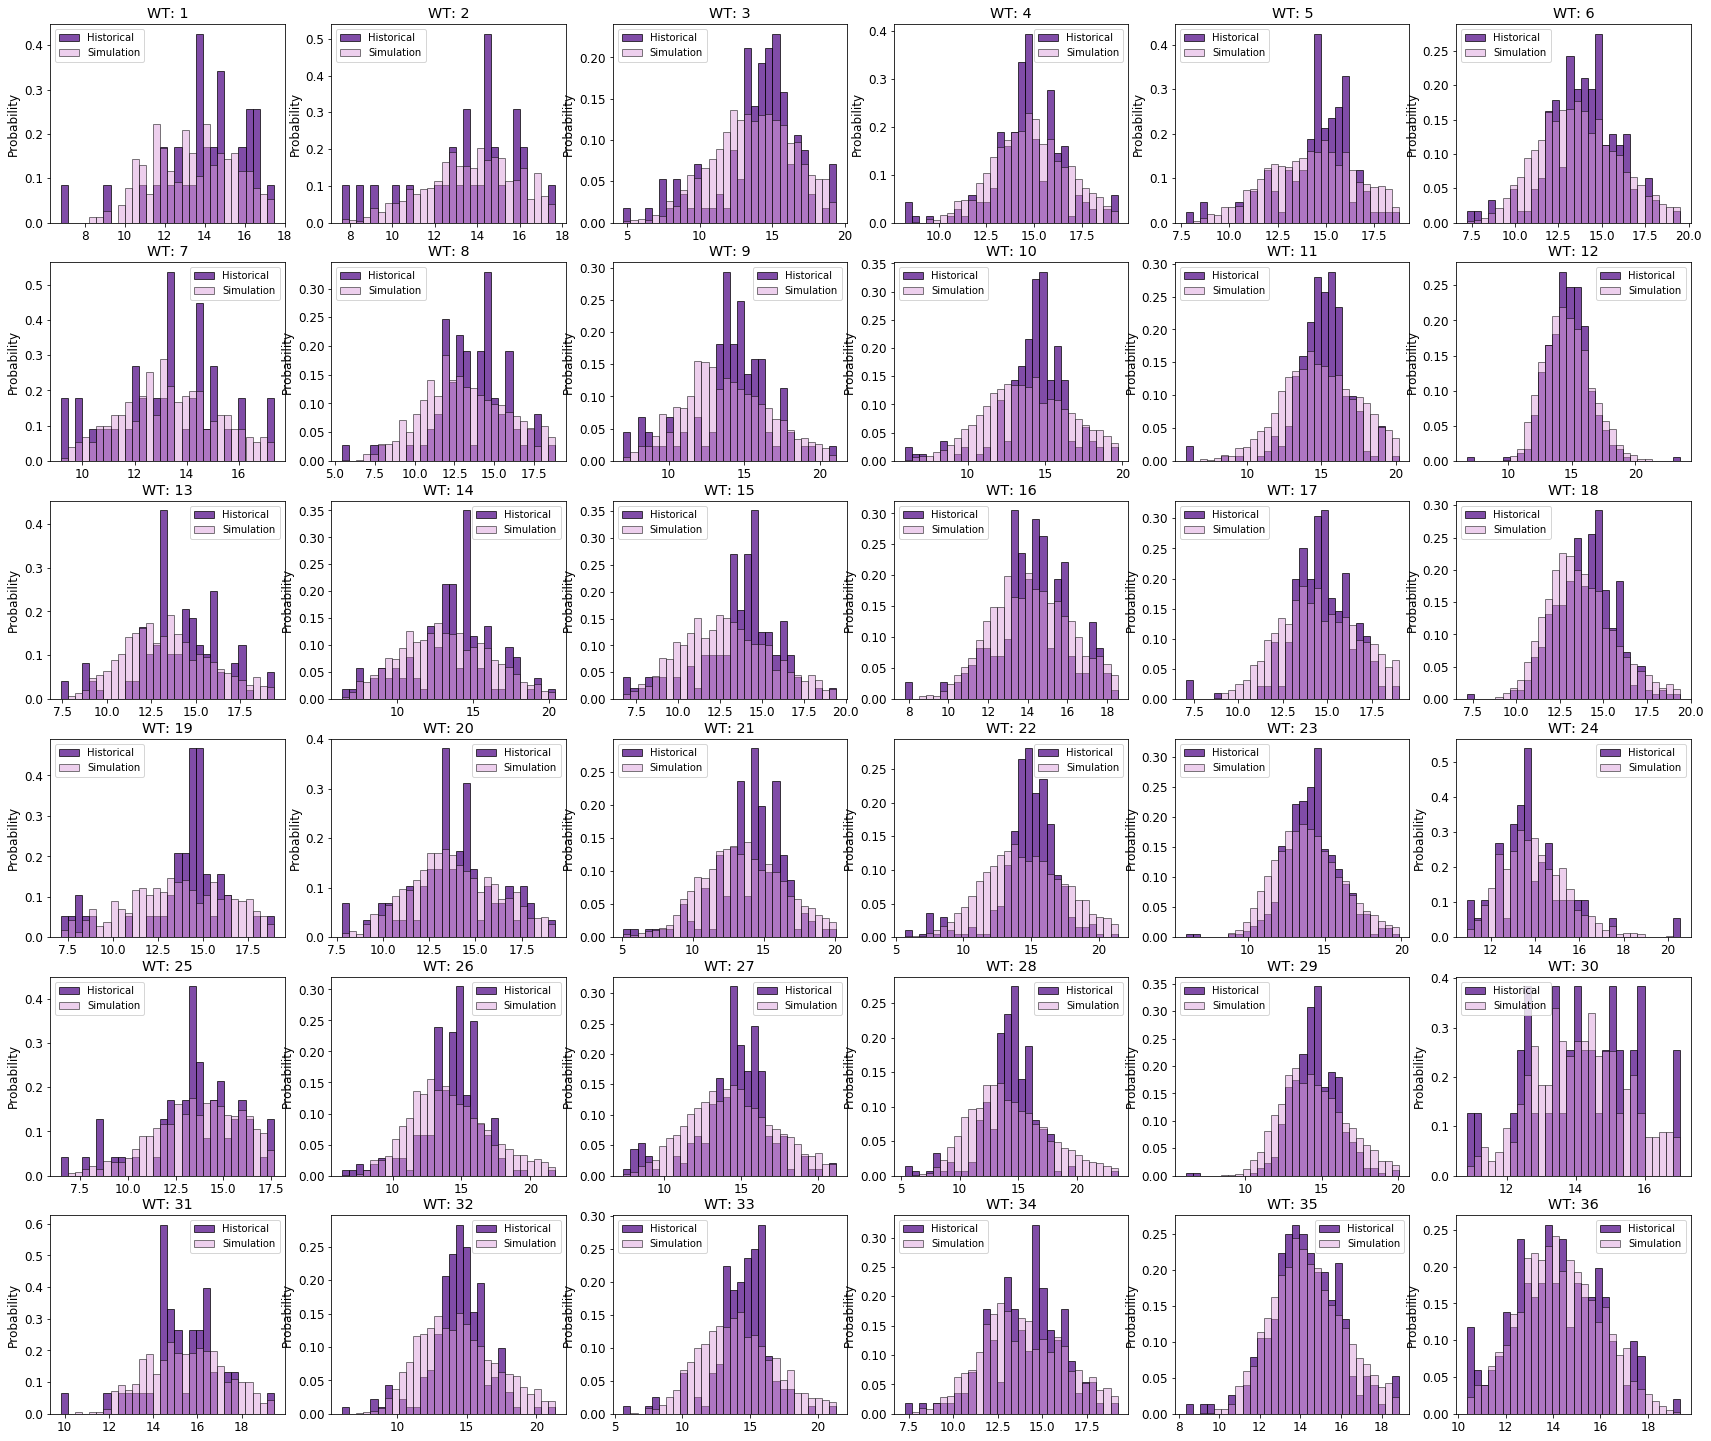

In [29]:
# Emp fit comparison
Plot_FitSim_EmpFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Tp', CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);


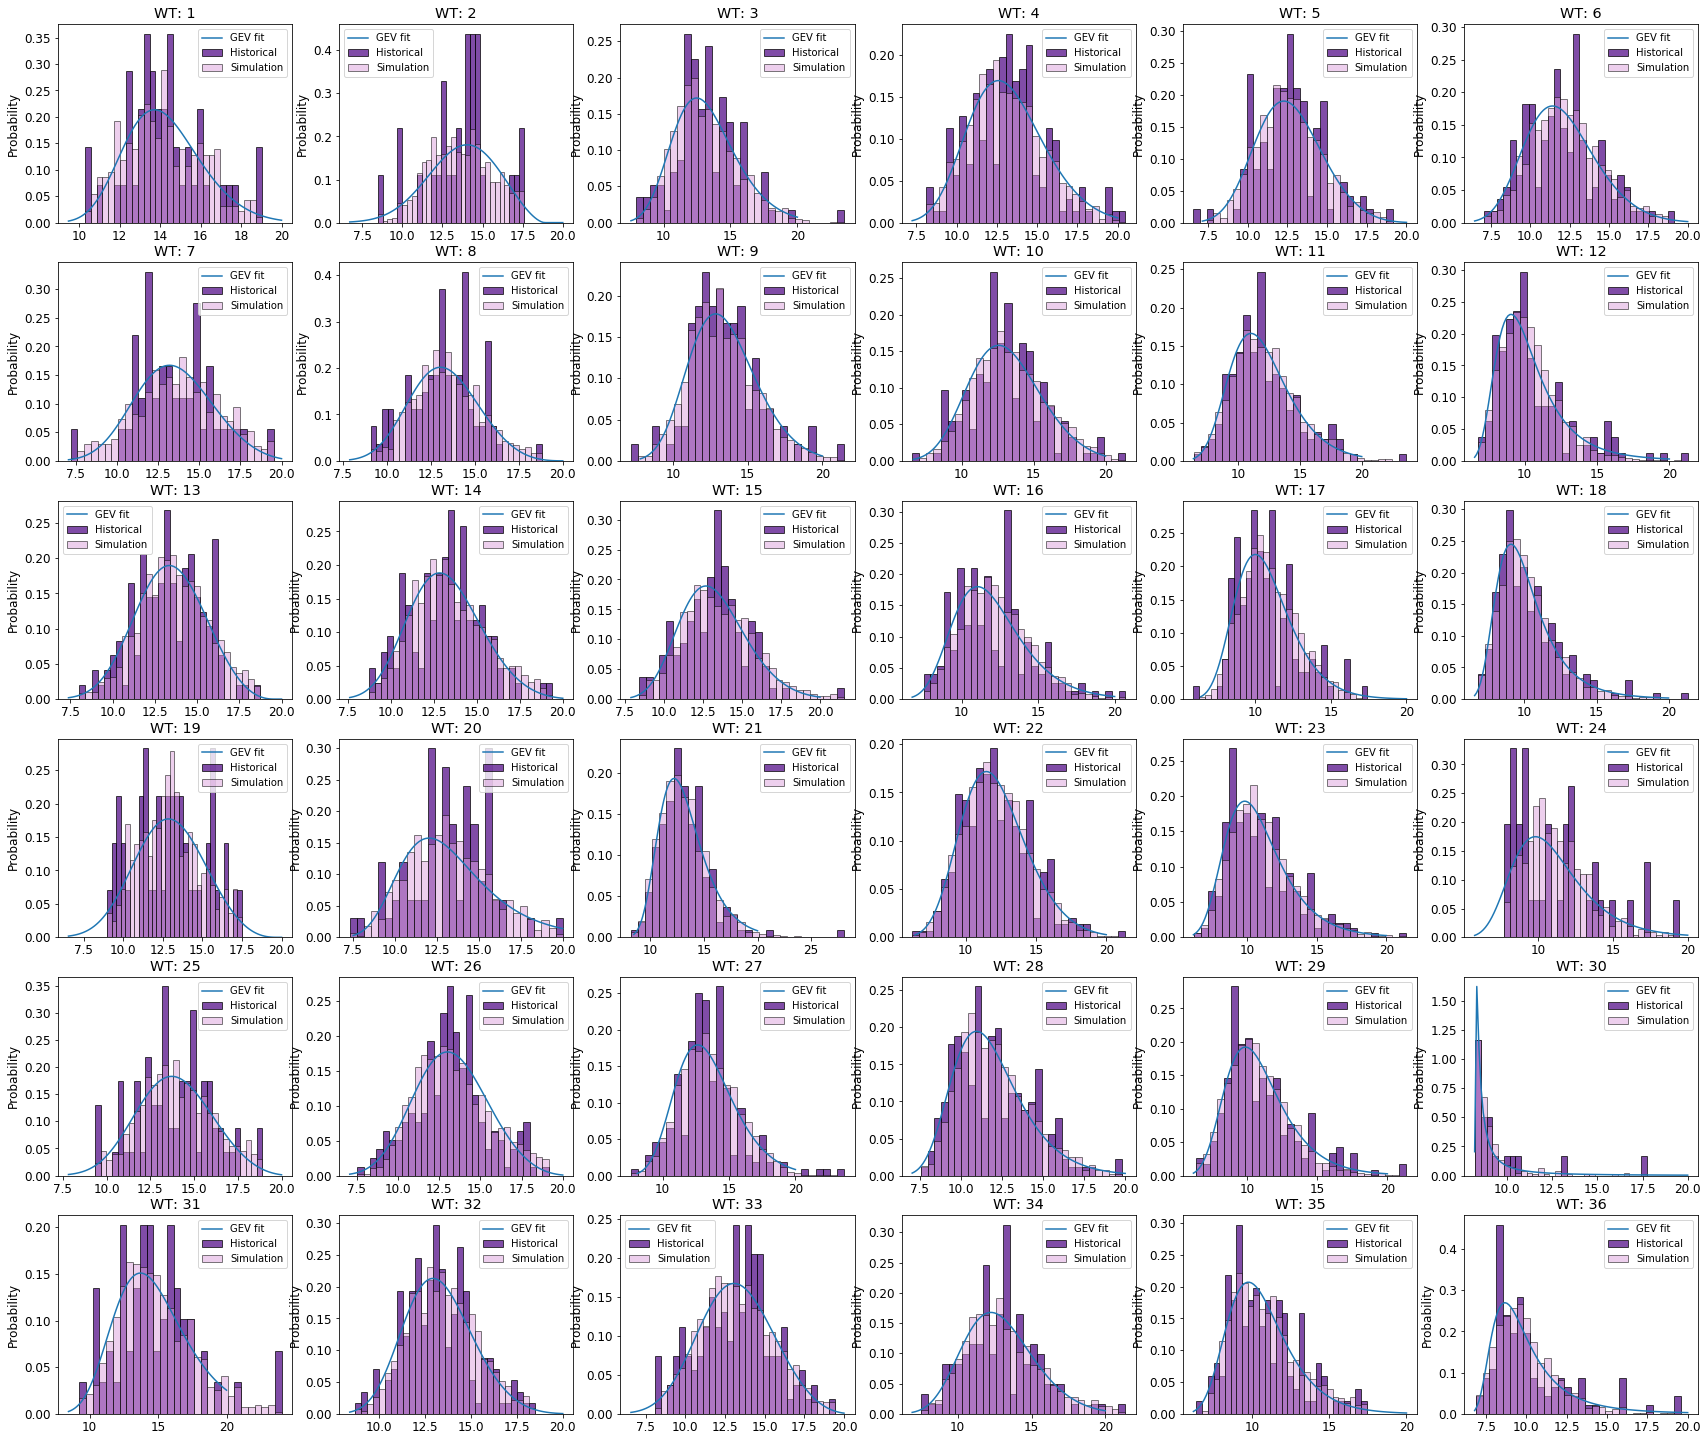

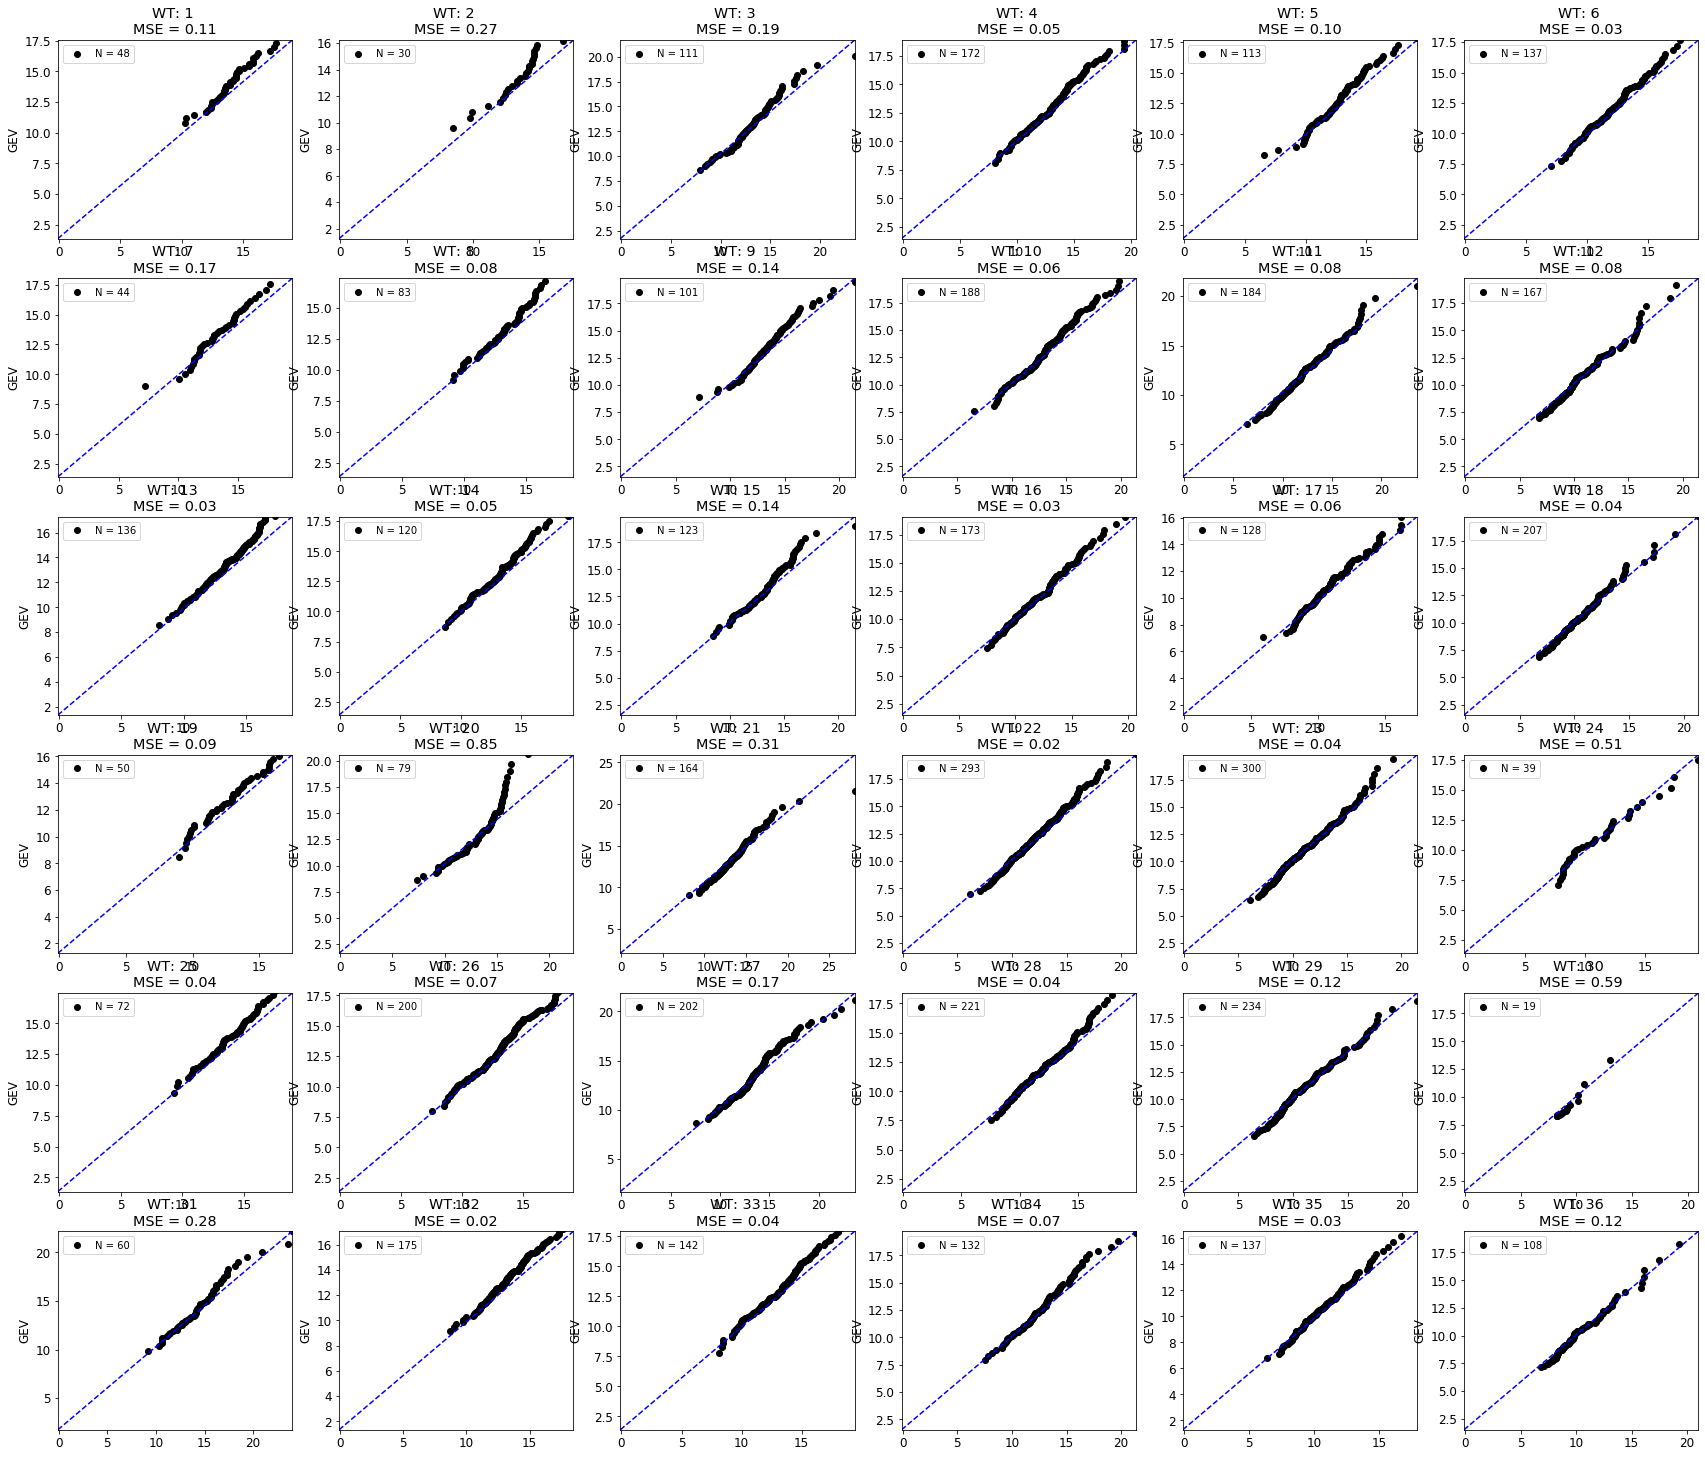

In [30]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);

## Climate Emulator Validation: Storm Surge; Sea Level Pressure; wind_u; wind_v

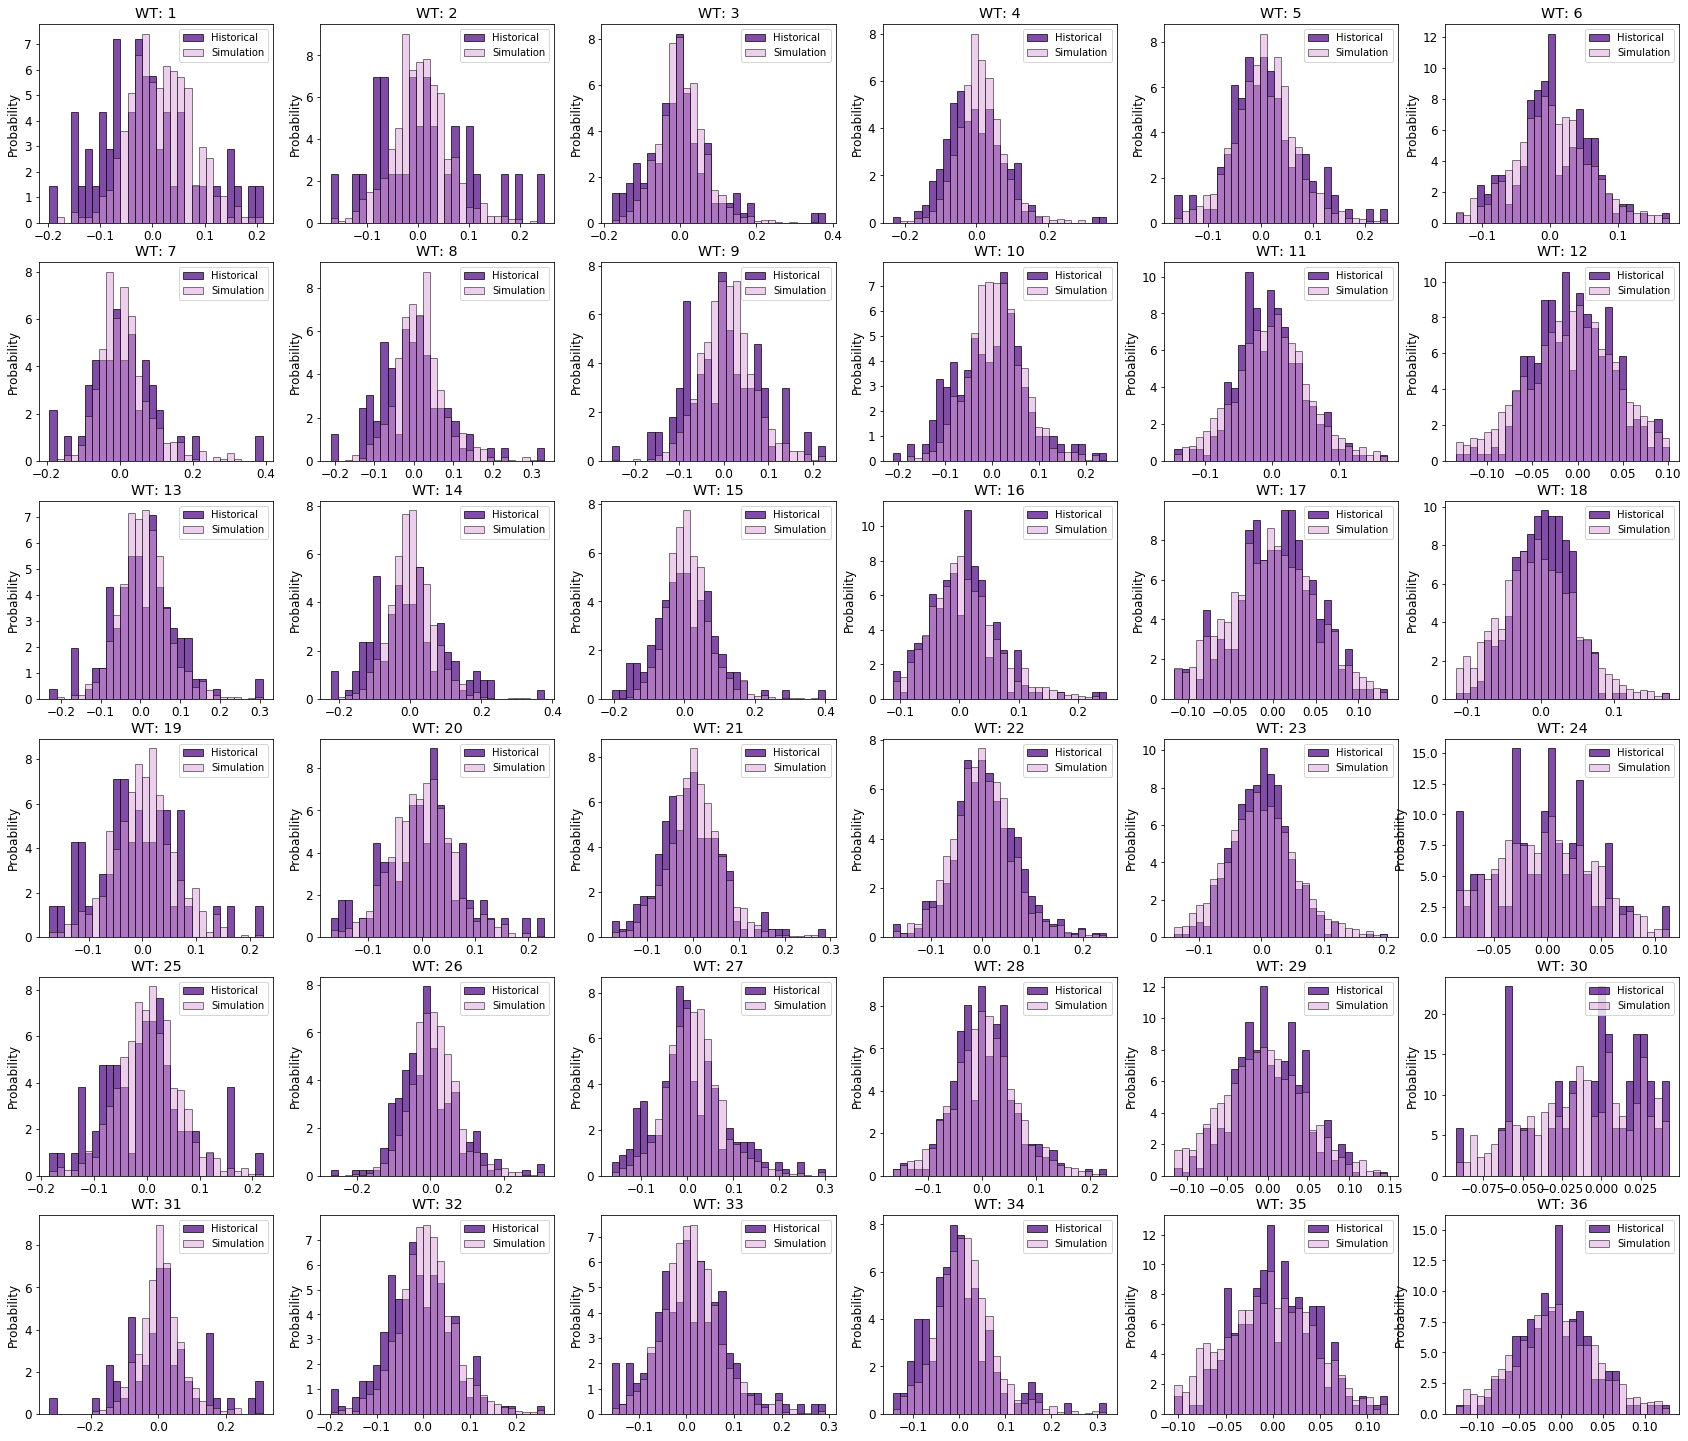

In [31]:
Plot_FitSim_EmpFit(
    WVS_fit_p, WVS_sim_ev, 'storm_surge', CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);


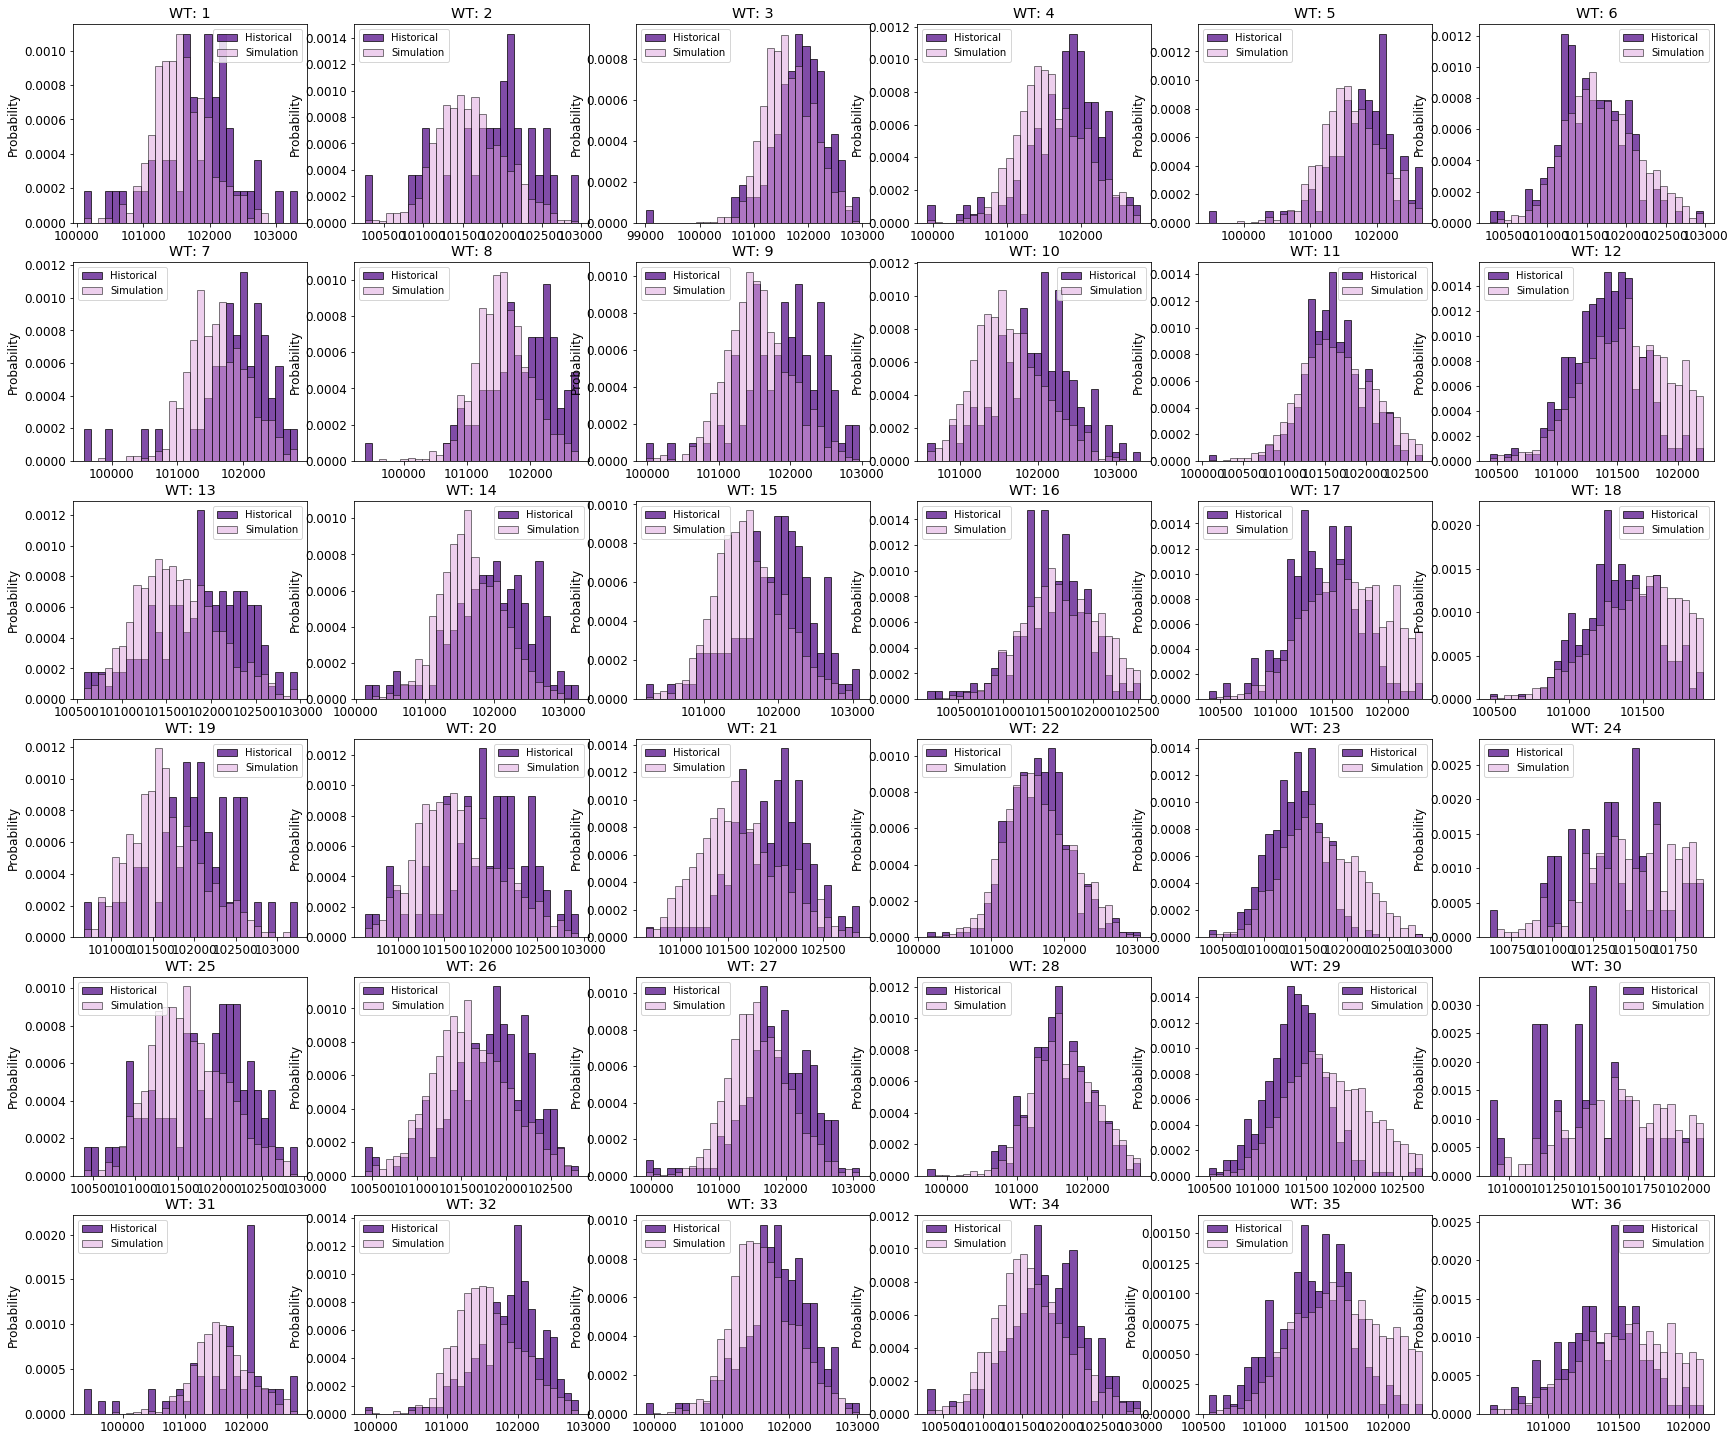

In [32]:
# Sea Level Pressure
Plot_FitSim_EmpFit(
    WVS_fit_p, WVS_sim_ev, 'sea_level_pressure', CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);


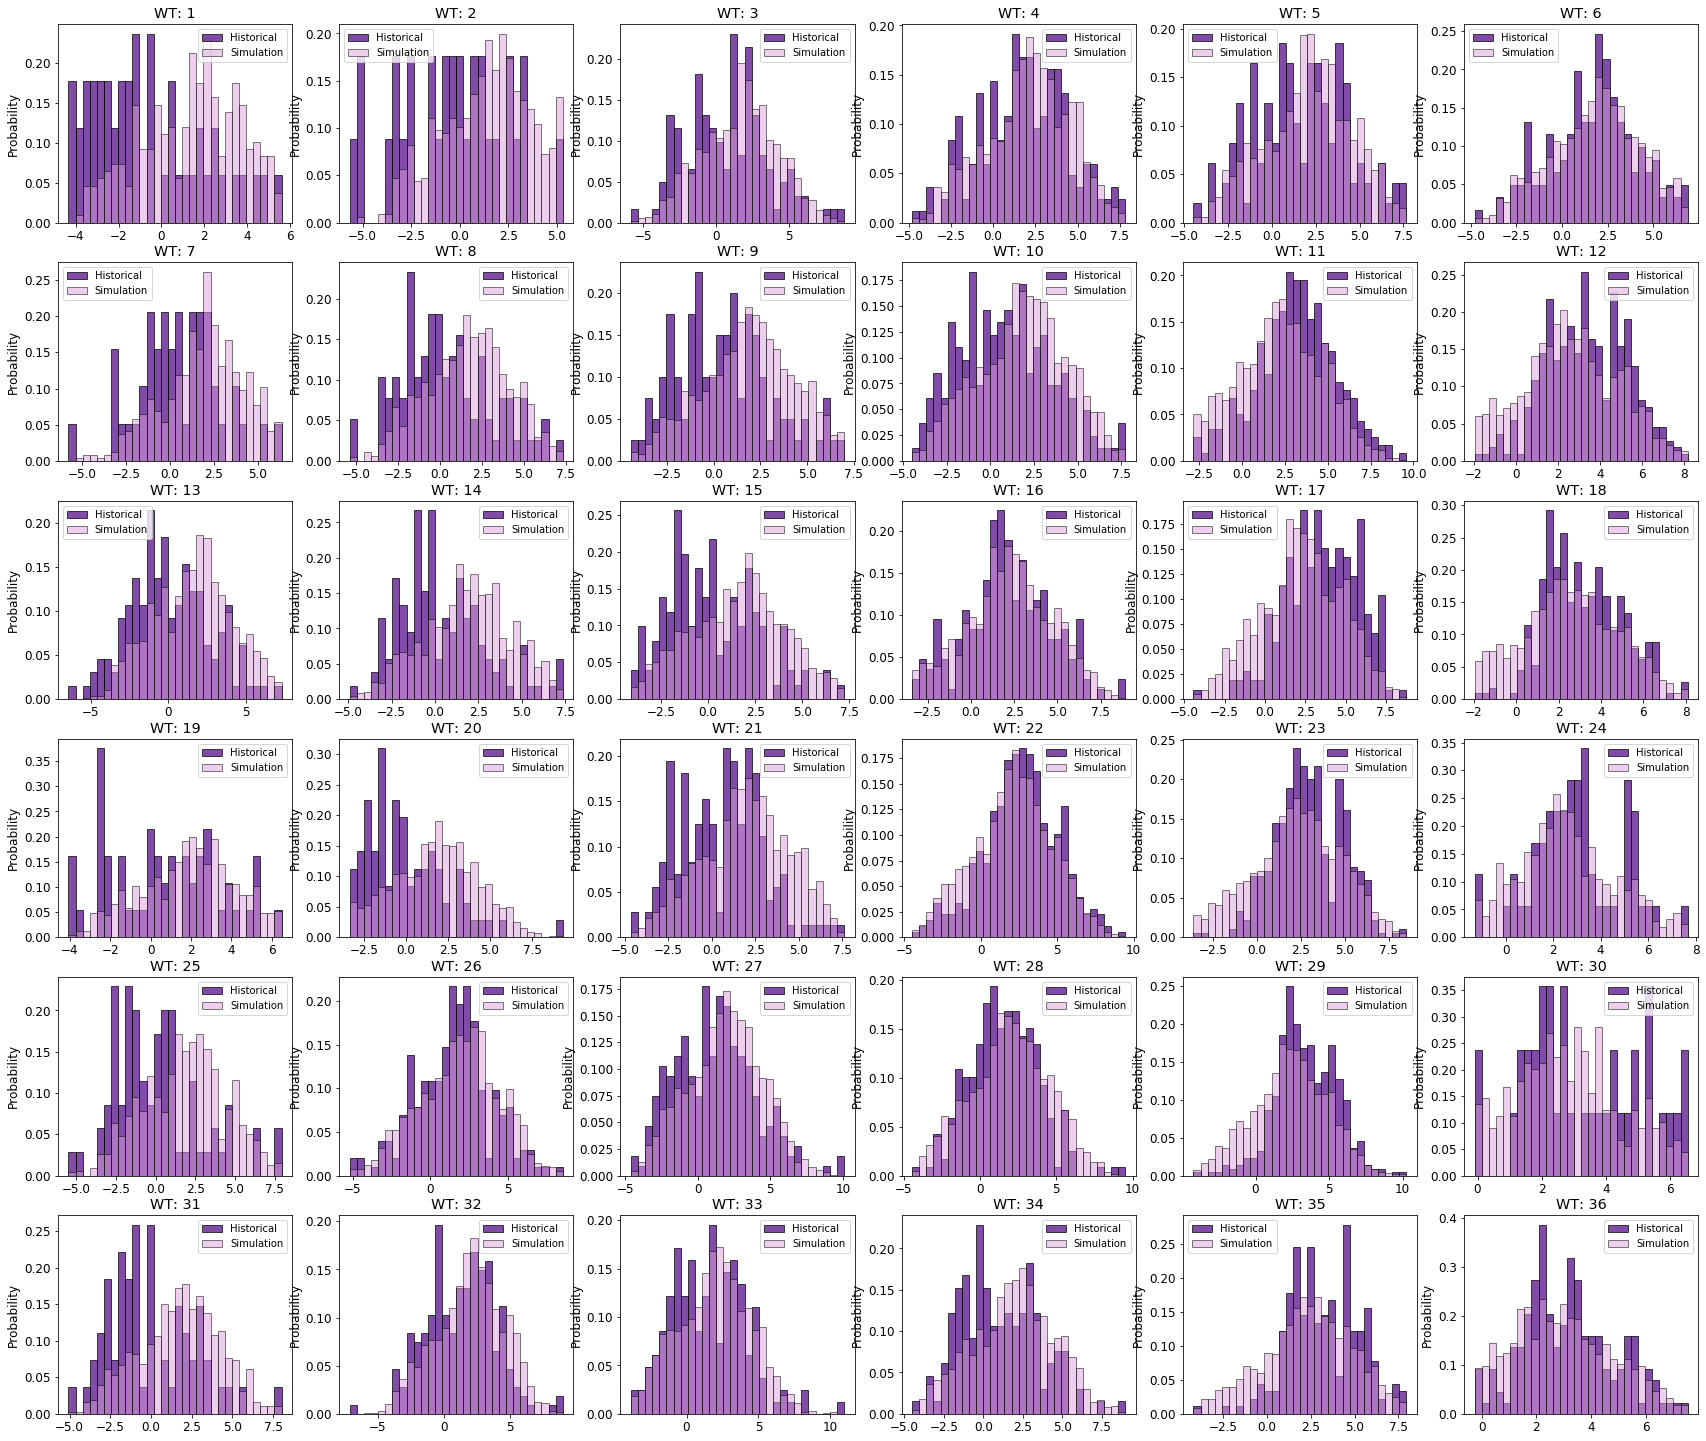

In [33]:
# wind u
Plot_FitSim_EmpFit(
    WVS_fit_p, WVS_sim_ev, 'wind_u', CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);


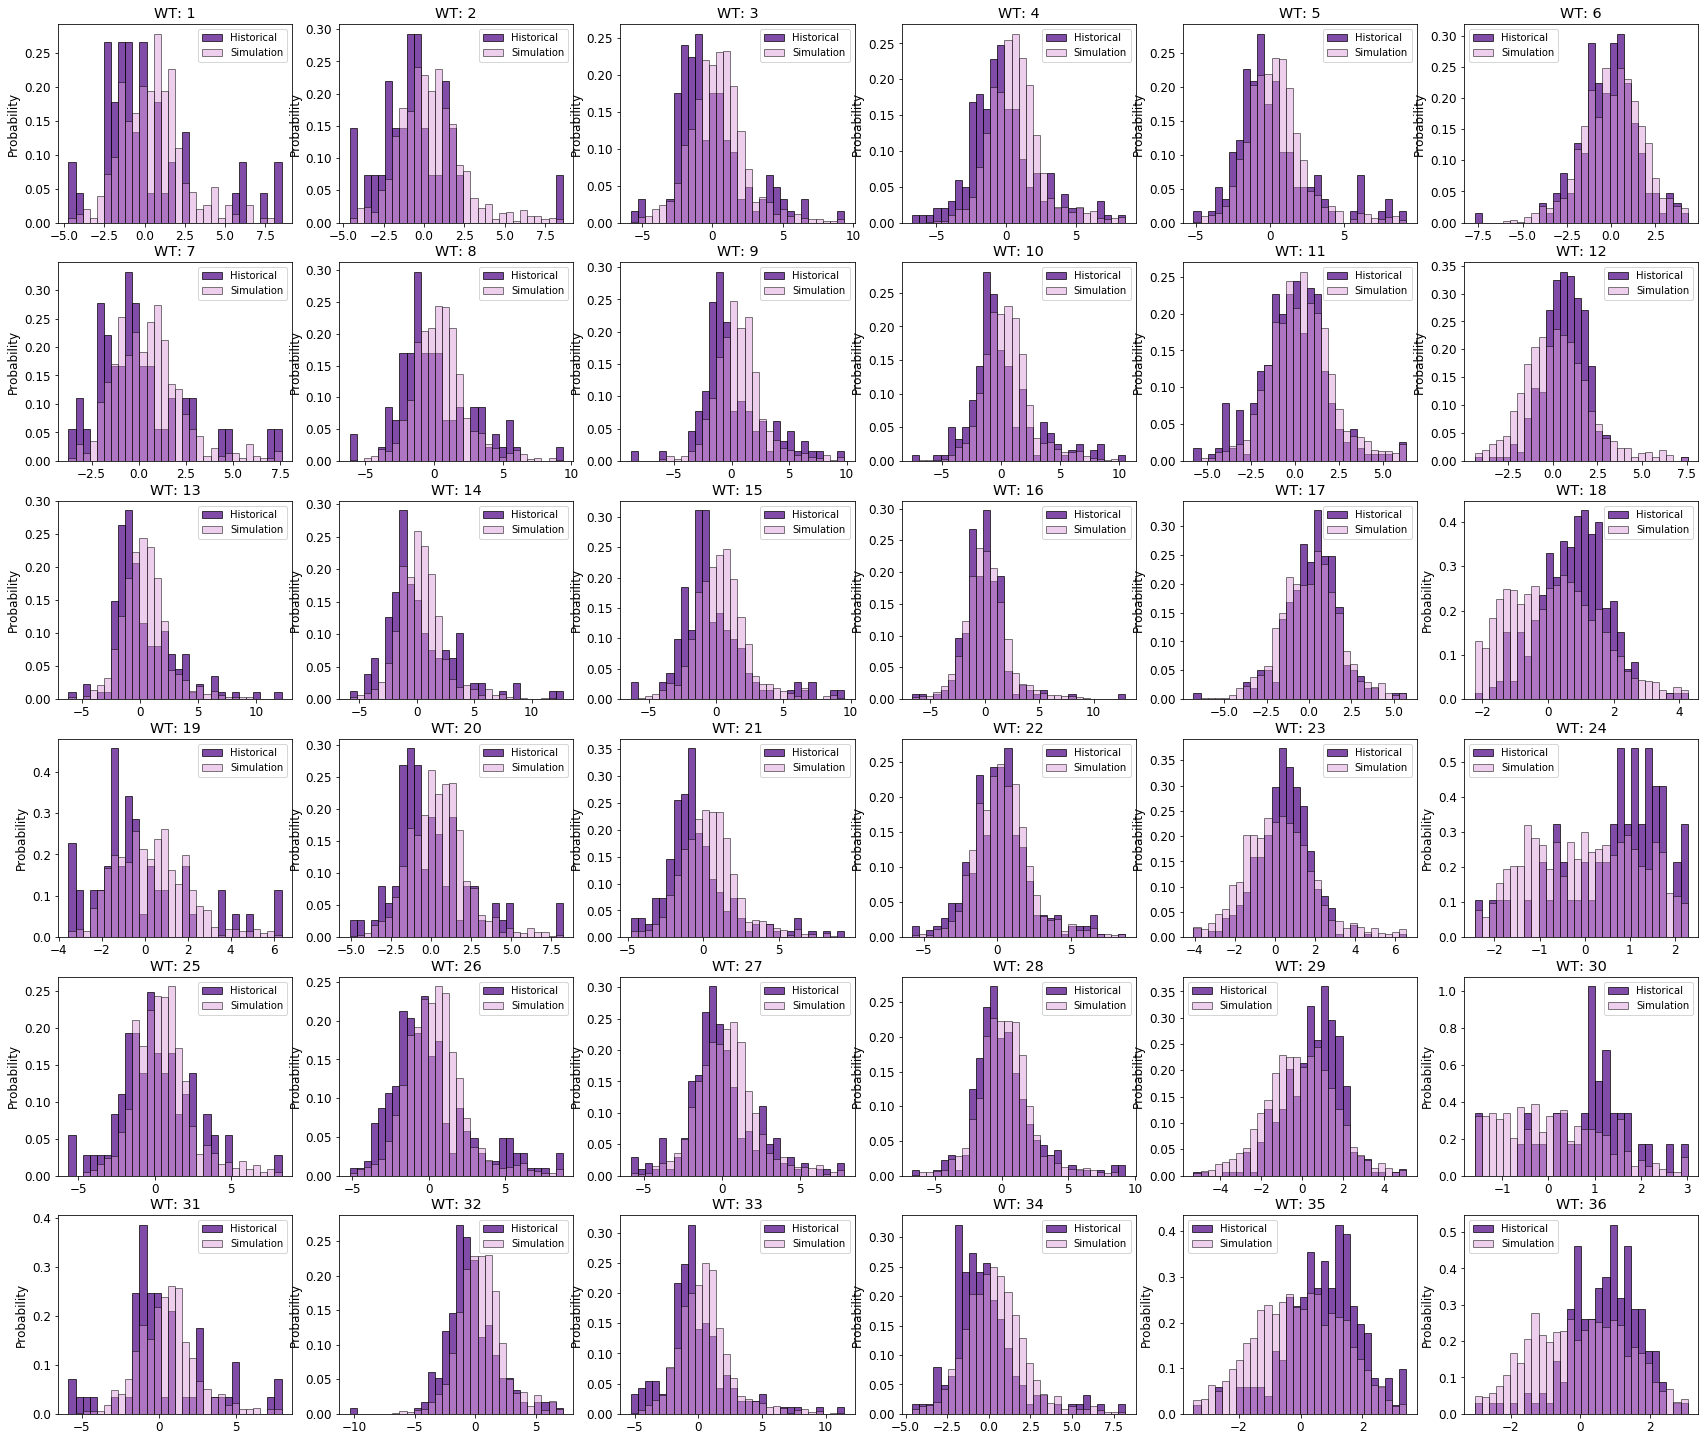

In [34]:
# wind v
Plot_FitSim_EmpFit(
    WVS_fit_p, WVS_sim_ev, 'wind_v', CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);



## Climate Emulator Validation: Aggregated Waves Hs and Tp

In [35]:

# Aggregate Waves Families
WVS_fit_agr = Aggregate_WavesFamilies(WVS_fit_p, 'max_energy')
WVS_sim_agr = Aggregate_WavesFamilies(WVS_sim_p, 'max_energy')

# Calculate AWL
WVS_fit_agr['AWL'] = AWL(WVS_fit_agr['Hs'], WVS_fit_agr['Tp'])
WVS_sim_agr['AWL'] = AWL(WVS_sim_agr['Hs'], WVS_sim_agr['Tp'])


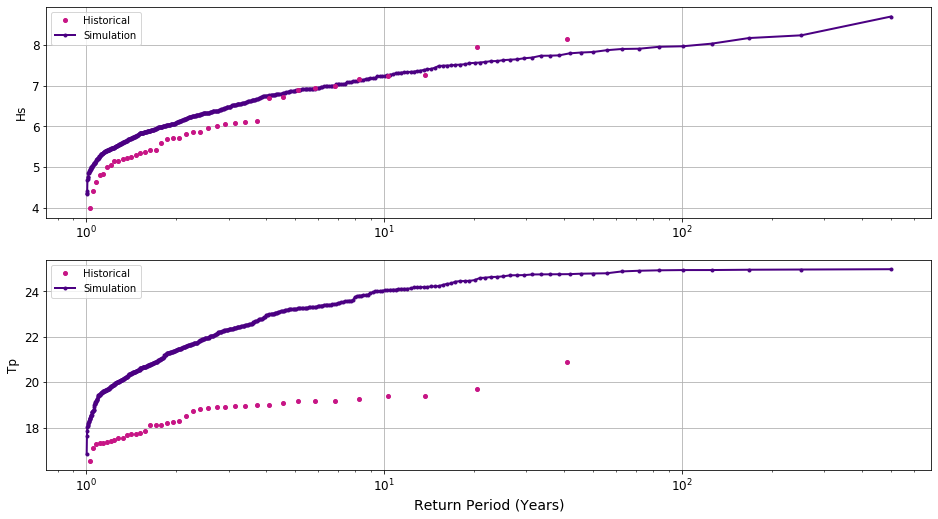

In [36]:
# Plot independent Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['Hs', 'Tp'],
    color_1='mediumvioletred', color_2='indigo',
);



## Climate Emulator Validation: AWL and marginal Hs, Tp

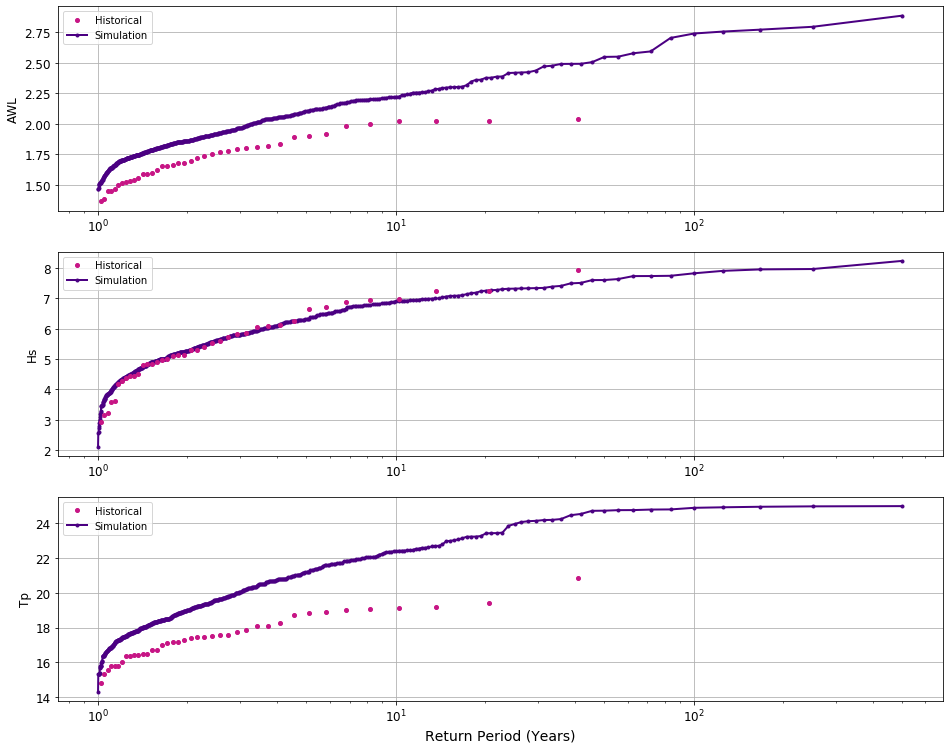

In [37]:
# TODO plot percentiles (como en nb14)

# Plot AWL and marginals (Hs, Tp) Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['AWL', 'Hs', 'Tp'], vn_max='AWL',
    color_1='mediumvioletred', color_2='indigo',
);
